In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uk-accident-data-set-2024/dft-road-casualty-statistics-collision-2024.csv
/kaggle/input/uk-accident-data-set-2024/dft-road-casualty-statistics-vehicle-2024.csv
/kaggle/input/uk-accident-data-set-2024/dft-road-casualty-statistics-road-safety-open-dataset-data-guide-2024.xlsx
/kaggle/input/uk-accident-data-set-2024/dft-road-casualty-statistics-casualty-2024.csv


In [41]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from scipy.sparse import csr_matrix
from tensorflow.keras.callbacks import EarlyStopping
from itertools import product
import io
import gc
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

tf.get_logger().setLevel('ERROR')

CODE_MAPPINGS_DICT = {
    "day_of_week": {1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday", 5: "Thursday", 6: "Friday", 7: "Saturday", -1: "Unknown/Missing", 99: "Unknown"},
    "first_road_class": {1: "Motorway", 2: "A(M)", 3: "A", 4: "B", 5: "C", 6: "Unclassified", -1: "Unknown/Missing", 99: "Unknown"},
    "road_type": {1: "Roundabout", 2: "One way street", 3: "Dual carriageway", 6: "Single carriageway", 7: "Slip road", 9: "Unknown", 12: "One way street/Slip road", -1: "Unknown/Missing", 99: "Unknown"},
    "junction_detail": {0: "Not at junction or within 20 metres", 13: "T or staggered junction", 16: "Crossroads", 17: "Junction with more than four arms (not roundabout)", 18: "Using private drive or entrance", 99: "unknown (self reported)", -1: "Unknown/Missing"},
    "junction_control": {0: "Not at junction or within 20 metres", 1: "Authorised person", 2: "Auto traffic signal", 3: "Stop sign", 4: "Give way or uncontrolled", -1: "Unknown/Missing", 9: "unknown (self reported)", 99: "Unknown"},
    "second_road_class": {0: "Not at junction or within 20 metres", 1: "Motorway", 2: "A(M)", 3: "A", 4: "B", 5: "C", 6: "Unclassified", 9: "Unknown (self rep only)", -1: "Unknown/Missing", 99: "Unknown"},
    "pedestrian_crossing": {0: "No physical crossing facility within 50m", 11: "Human crossing control by school crossing patrol", 12: "Human crossing control by other authorised person", 13: "Zebra crossing", 14: "Pedestrian light crossing (pelican or puffin or toucan or similar)", 15: "Pedestrian phase at traffic signal", 16: "Footbridge or subway", 17: "Central refuge - no other controls", 99: "unknown (self reported)", -1: "Unknown/Missing"},
    "light_conditions": {1: "Daylight", 4: "Darkness - lights lit", 5: "Darkness - lights unlit", 6: "Darkness - no lighting", 7: "Darkness - lighting unknown", -1: "Unknown/Missing", 99: "Unknown"},
    "weather_conditions": {1: "Fine no high winds", 2: "Raining no high winds", 3: "Snowing no high winds", 4: "Fine + high winds", 5: "Raining + high winds", 6: "Snowing + high winds", 7: "Fog or mist", 8: "Other", 9: "Unknown", -1: "Unknown/Missing", 99: "Unknown"},
    "road_surface_conditions": {1: "Dry", 2: "Wet or damp", 3: "Snow", 4: "Frost or ice", 5: "Flood over 3cm. deep", 6: "Oil or diesel", 7: "Mud", -1: "Unknown/Missing", 9: "unknown (self reported)", 99: "Unknown"},
    "special_conditions_at_site": {0: "None", 1: "Auto traffic signal - out", 2: "Auto signal part defective", 3: "Road sign or marking defective or obscured", 4: "Roadworks", 5: "Road surface defective", 6: "Oil or diesel", 7: "Mud", -1: "Unknown/Missing", 9: "unknown (self reported)", 99: "Unknown"},
    "carriageway_hazards": {0: "None", 11: "Defective traffic signals", 12: "Permanent road signing or markings defective or obscured or inadequate", 13: "Roadworks", 14: "Oil or diesel", 15: "Mud", 16: "Dislodged vehicle load in carriageway", 17: "Other object in carriageway", 18: "Involvement with previous collision", 19: "Pedestrian in carriageway - not injured", 20: "Any animal in carriageway (except ridden horse)", 21: "Poor or defective road surface", -1: "Unknown/Missing", 99: "unknown (self reported)"},
    "urban_or_rural_area": {1: "Urban", 2: "Rural", 3: "Unallocated", -1: "Unknown/Missing", 99: "Unknown"},
    "vehicle_type": {1: "Pedal cycle", 2: "Motorcycle 50cc and under", 3: "Motorcycle 125cc and under", 4: "Motorcycle over 125cc and up to 500cc", 5: "Motorcycle over 500cc", 8: "Taxi/Private hire car", 9: "Car", 10: "Minibus (8 - 16 passenger seats)", 11: "Bus or coach (17 or more pass seats)", 16: "Ridden horse", 17: "Agricultural vehicle", 18: "Tram", 19: "Van / Goods 3.5 tonnes mgw or under", 20: "Goods over 3.5t. and under 7.5t", 21: "Goods 7.5 tonnes mgw and over", 22: "Mobility scooter", 23: "Electric motorcycle", 90: "Other vehicle", 97: "Motorcycle - unknown cc", 98: "Goods vehicle - unknown weight", 99: "Unknown vehicle type (self rep only)", -1: "Unknown/Missing"},
    "towing_and_articulation": {0: "No tow/articulation", 1: "Articulated vehicle", 2: "Double or multiple trailer", 3: "Caravan", 4: "Single trailer", 5: "Other tow", 9: "unknown (self reported)", -1: "Unknown/Missing", 99: "Unknown"},
    "vehicle_manoeuvre": {1: "Reversing", 2: "Parked", 3: "Waiting to go ahead", 4: "Slowing or stopping", 5: "Moving off", 6: "U-turn", 7: "Turning left", 8: "Waiting to turn left", 9: "Turning right", 10: "Waiting to turn right", 11: "Changing lane to left", 12: "Changing lane to right", 13: "Over taking moving vehicle on its offside", 14: "Overtaking stationary vehicle on its offside", 15: "Overtaking on nearside (passengers side nearest kerb)", 19: "Going ahead", 20: "Parking", 99: "unknown (self reported)", -1: "Unknown/Missing"},
    "vehicle_location_restricted_lane": {0: "On main carriageway (not in restricted lane)", 1: "Tram or Light rail track", 2: "Bus lane or Busway", 4: "Cycle lane (on main carriageway)", 5: "Cycleway or shared use footway (not part of main carriageway)", 6: "Lay-by or hard shoulder", 9: "Footway (pavement)", 99: "unknown (self reported)", -1: "Unknown/Missing"},
    "junction_location": {0: "Not at or within 20 metres of junction", 1: "Approaching junction or waiting/parked at junction approach", 2: "Cleared junction or waiting/parked at junction exit", 3: "Leaving roundabout", 4: "Entering roundabout", 5: "Leaving main road", 6: "Entering main road", 7: "Entering from slip road", 8: "Mid Junction - on roundabout or on main road", 9: "unknown (self reported)", -1: "Unknown/Missing", 99: "Unknown"},
    "vehicle_left_hand_drive": {1: "No", 2: "Yes", 9: "Unknown", -1: "Unknown/Missing", 99: "Unknown"},
    "journey_purpose_of_driver": {1: "Journey as part of work", 2: "Commuting to or from work", 6: "Not known or not requested", 7: "Education and educational escort", 8: "Emergency vehicle (blue light) on response", 9: "Personal business or leisure", -1: "Unknown/Missing", 99: "Unknown"},
    "sex_of_driver": {1: "Male", 2: "Female", 3: "Not known", -1: "Unknown/Missing", 99: "Unknown"},
    "age_band_of_driver": {1: "0 - 5", 2: "6 - 10", 3: "11 - 15", 4: "16 - 20", 5: "21 - 25", 6: "26 - 30", 7: "31 - 35", 8: "36 - 40", 9: "41 - 45", 10: "46 - 50", 11: "51 - 55", 12: "56 - 60", 13: "61 - 65", 14: "66 - 70", 15: "71+", -1: "Unknown/Missing", 99: "Unknown"},
    "propulsion_code": {1: "Petrol", 2: "Heavy oil", 3: "Electric", 4: "Gas", 5: "Hybrid electric", 6: "Other", 7: "Unknown", 99: "Unknown", -1: "Unknown/Missing"},
    "driver_imd_decile": {1: "1 (Most deprived)", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9", 10: "10 (Least deprived)", -1: "Unknown/Missing", 99: "Unknown"},
    "escooter_flag": {0: "No", 1: "Yes", 99: "Unknown", -1: "Unknown/Missing"},
    "driver_distance_banding": {1: "0-1 miles", 2: "1-2 miles", 3: "2-5 miles", 4: "5-10 miles", 5: "10-25 miles", 6: "25-50 miles", 7: "50+ miles", 9: "Unknown", -1: "Unknown/Missing", 99: "Unknown"},
    "junction_detail_historic": {0: "Not at junction or within 20 metres", 1: "Roundabout", 2: "Mini-roundabout", 3: "T or staggered junction", 5: "Slip road junction", 6: "Crossroads", 7: "Junction with more than four arms (not roundabout)", 18: "Using private drive or entrance", 99: "unknown (self reported)", -1: "Unknown/Missing"},
    "pedestrian_crossing_human_control_historic": {0: "No human control within 50 metres", 1: "Control by school crossing patrol", 2: "Control by other authorised person", -1: "Unknown/Missing", 99: "Unknown"},
    "pedestrian_crossing_physical_facilities_historic": {0: "No physical crossing facilities within 50 metres", 1: "Zebra crossing", 4: "Pelican, puffin or toucan light crossing", 5: "Light controlled crossing (other than above)", 6: "Footbridge or subway", 7: "Central refuge", 8: "Other physical crossing facility", -1: "Unknown/Missing", 99: "Unknown"},
    "carriageway_hazards_historic": {0: "None", 1: "Previous accident", 2: "Other non-fixed object on road", 3: "Involvement with previous accident", 4: "Dislodged vehicle load in carriageway", 5: "Any animal in carriageway (except ridden horse)", 6: "Broken down vehicle (other than involved in the accident)", 7: "Other object in carriageway", -1: "Unknown/Missing", 99: "Unknown"},
    "vehicle_manoeuvre_historic": {1: "Reversing", 2: "Parked", 3: "Waiting to go ahead", 4: "Slowing or stopping", 5: "Moving off", 6: "U-turn", 7: "Turning left", 8: "Waiting to turn left", 9: "Turning right", 10: "Waiting to turn right", 11: "Changing lane to left", 12: "Changing lane to right", 13: "Over taking moving vehicle on its offside", 14: "Overtaking stationary vehicle on its offside", 15: "Overtaking on nearside (passengers side nearest kerb)", 19: "Going ahead", 20: "Parking", 99: "unknown (self reported)", -1: "Unknown/Missing"},
    "vehicle_location_restricted_lane_historic": {0: "On main carriageway (not in restricted lane)", 1: "Tram or Light rail track", 2: "Bus lane or Busway", 4: "Cycle lane (on main carriageway)", 5: "Cycleway or shared use footway (not part of main carriageway)", 6: "Lay-by or hard shoulder", 9: "Footway (pavement)", 99: "unknown (self reported)", -1: "Unknown/Missing"},
    "journey_purpose_of_driver_historic": {1: "Journey as part of work", 2: "Commuting to or from work", 6: "Not known or not requested", 7: "Education and educational escort", 8: "Emergency vehicle (blue light) on response", 9: "Personal business or leisure", -1: "Unknown/Missing", 99: "Unknown"},
    "casualty_class": {1: "Driver or rider", 2: "Passenger", 3: "Pedestrian", -1: "Unknown/Missing", 9: "Unknown (self reported)", 99: "Unknown"},
    "sex_of_casualty": {1: "Male", 2: "Female", 3: "Not known", -1: "Unknown/Missing", 99: "Unknown"},
    "age_band_of_casualty": {1: "0 - 5", 2: "6 - 10", 3: "11 - 15", 4: "16 - 20", 5: "21 - 25", 6: "26 - 30", 7: "31 - 35", 8: "36 - 40", 9: "41 - 45", 10: "46 - 50", 11: "51 - 55", 12: "56 - 60", 13: "61 - 65", 14: "66 - 70", 15: "71+", -1: "Unknown/Missing", 99: "Unknown"},
}
for k in list(CODE_MAPPINGS_DICT.keys()):
    if 'coll' in k or 'veh' in k or 'cas' in k:
        base_k = k.split('_coll')[0].split('_veh')[0].split('_cas')[0]
        if base_k not in CODE_MAPPINGS_DICT:
            CODE_MAPPINGS_DICT[base_k] = CODE_MAPPINGS_DICT[k]

BAD_STRINGS = ["Unknown", "Unknown/Missing", "unknown (self reported)", "Unknown (self rep only)"]
REDUCED_FEATURE_COLUMNS = [
    'day_of_week', 'time', 'urban_or_rural_area', 'speed_limit', 'first_road_class', 'road_type',
    'junction_detail', 'junction_control', 'second_road_class', 'pedestrian_crossing', 'trunk_road_flag',
    'light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site',
    'junction_location', 'carriageway_hazards', 'junction_detail_historic', 
    'pedestrian_crossing_human_control_historic', 'pedestrian_crossing_physical_facilities_historic',
    'carriageway_hazards_historic', 'vehicle_type', 'towing_and_articulation', 'vehicle_manoeuvre',
    'vehicle_manoeuvre_historic', 'vehicle_location_restricted_lane', 'vehicle_left_hand_drive', 
    'journey_purpose_of_driver', 'sex_of_driver', 'age_band_of_driver', 'propulsion_code', 
    'driver_imd_decile', 'escooter_flag', 'driver_distance_banding'
]

def load_and_map_data():
    collision_path = "/kaggle/input/uk-accident-data-set-2024/dft-road-casualty-statistics-collision-2024.csv"
    vehicle_path   = "/kaggle/input/uk-accident-data-set-2024/dft-road-casualty-statistics-vehicle-2024.csv"
    casualty_path  = "/kaggle/input/uk-accident-data-set-2024/dft-road-casualty-statistics-casualty-2024.csv"
    try:
        df_collision = pd.read_csv(collision_path, low_memory=False)
        df_vehicle   = pd.read_csv(vehicle_path, low_memory=False)
        df_casualty  = pd.read_csv(casualty_path, low_memory=False)
    except FileNotFoundError:
        print("Warning: Data files not found. Creating dummy data to proceed.")
        data = {'collision_index': [1,2,3,4,5], 'collision_severity': [1, 2, 3, 3, 2], 'light_conditions': [1, 4, 1, 5, 4], 'road_surface_conditions': [1, 2, 1, 4, 2], 'speed_limit': [30, 60, 30, 70, 40], 'vehicle_reference': [1, 1, 1, 1, 1], 'day_of_week': [2, 3, 4, 5, 6]}
        df_collision = pd.DataFrame(data)
        df_vehicle = pd.DataFrame({'collision_index': [1,2,3,4,5], 'vehicle_reference': [1, 1, 1, 1, 1], 'vehicle_type': [9, 9, 1, 9, 1]})
        df_casualty = pd.DataFrame({'collision_index': [1,2,3,4,5], 'vehicle_reference': [1, 1, 1, 1, 1], 'casualty_class': [1, 2, 3, 1, 2]})

    for df_ in [df_collision, df_vehicle, df_casualty]:
        df_.columns = df_.columns.str.lower().str.strip().str.replace(' ', '_')
    key = 'collision_index' if 'collision_index' in df_collision.columns else 'accident_index'
    df = df_collision.merge(df_vehicle, on=key, how='left', suffixes=('_coll', '_veh'))
    df = df.merge(df_casualty, left_on=[key, 'vehicle_reference'], right_on=[key, 'vehicle_reference'], how='left', suffixes=('', '_cas'))
    df = df.dropna(subset=['collision_severity', 'light_conditions', 'road_surface_conditions', 'speed_limit']).copy()
    df['collision_severity'] = pd.to_numeric(df['collision_severity'], errors='coerce', downcast='integer')
    df['speed_limit'] = pd.to_numeric(df['speed_limit'], errors='coerce', downcast='integer').fillna(0)
    df = df[df['collision_severity'].isin([1, 2, 3])].reset_index(drop=True)
    
    for col in df.columns:
        col_key = col.split('_coll')[0].split('_veh')[0].split('_cas')[0]
        if col_key in CODE_MAPPINGS_DICT:
            mapping = CODE_MAPPINGS_DICT[col_key]
            if pd.api.types.is_numeric_dtype(df[col]):
                 df[col] = df[col].map(mapping).fillna(df[col])
                 
    DARK_LABELS = ['Darkness - lights lit', 'Darkness - lights unlit', 'Darkness - no lighting', 'Darkness - lighting unknown']
    POOR_SURFACE_LABELS = ['Wet or damp', 'Snow', 'Frost or ice', 'Flood over 3cm. deep', 'Oil or diesel', 'Mud']
    HIGH_SPEED_LIMIT = 60
    df['is_dark'] = df['light_conditions'].astype(str).str.contains('|'.join(DARK_LABELS), na=False)
    df['is_poor_surface'] = df['road_surface_conditions'].astype(str).str.contains('|'.join(POOR_SURFACE_LABELS), na=False)
    df['is_high_speed'] = df['speed_limit'] >= HIGH_SPEED_LIMIT
    
    return df

def create_target_data(df_in, target_type):
    df_temp = df_in.copy()
    
    if target_type == '2-Class':
        df_temp['target'] = df_temp['collision_severity'].apply(lambda x: 'High_Severity' if x in (1, 2) else 'Slight')
    elif target_type == '3-Class':
        df_temp['target'] = df_temp['collision_severity'].map({1: 'Fatal', 2: 'Serious', 3: 'Slight'})
    elif target_type == '5-Class':
        def map_5_class(row):
            if row['collision_severity'] in (1, 2): return 'High_Severity'
            elif row['is_dark'] and not row['is_poor_surface']: return 'Slight_DARKNESS_RISK'
            elif row['is_poor_surface']: return 'Slight_SURFACE_RISK'
            else:
                if row['is_high_speed']: return 'Slight_LOW_HIGH_SPEED'
                else: return 'Slight_LOW_NORMAL_SPEED'
            return 'Unknown'
        df_temp['target'] = df_temp.apply(map_5_class, axis=1)
    elif target_type == '6-Class':
        def map_6_class(row):
            if row['collision_severity'] == 1: return 'Fatal'
            elif row['collision_severity'] == 2: return 'Serious'
            elif row['is_dark'] and not row['is_poor_surface']: return 'Slight_DARKNESS_RISK'
            elif row['is_poor_surface']: return 'Slight_SURFACE_RISK'
            else:
                if row['is_high_speed']: return 'Slight_LOW_RISK_HIGH_SPEED'
                else: return 'Slight_LOW_RISK_NORMAL_SPEED'
            return 'Unknown'
        df_temp['target'] = df_temp.apply(map_6_class, axis=1)

    df_temp = df_temp.dropna(subset=['target'])
    df_temp = df_temp[df_temp['target'] != 'Unknown'].reset_index(drop=True)
    le = LabelEncoder()
    y = le.fit_transform(df_temp['target'])
    return y, le.classes_, df_temp.index.values

def get_custom_weights(y_train, target_names, target_type):
    classes, class_counts = np.unique(y_train, return_counts=True)
    weights = len(y_train) / (len(classes) * class_counts)
    weight_dict = {i: weight for i, weight in enumerate(weights)}
    le = LabelEncoder().fit(target_names)
    
    if target_type == '2-Class-Base':
        if 'High_Severity' in target_names:
            weight_dict[le.transform(['High_Severity'])[0]] *= 3.5
    elif target_type == '2-Class-Aggressive':
        if 'High_Severity' in target_names:
            weight_dict[le.transform(['High_Severity'])[0]] *= 4.5 
    elif target_type == '3-Class-Base':
        if 'Fatal' in target_names: weight_dict[le.transform(['Fatal'])[0]] *= 3.0
        if 'Serious' in target_names: weight_dict[le.transform(['Serious'])[0]] *= 2.0
    elif target_type == '3-Class-Aggressive':
        if 'Fatal' in target_names: weight_dict[le.transform(['Fatal'])[0]] *= 5.0
        if 'Serious' in target_names: weight_dict[le.transform(['Serious'])[0]] *= 3.0
    elif target_type == '5-Class-Base':
         if 'High_Severity' in target_names:
            weight_dict[le.transform(['High_Severity'])[0]] *= 3.5
    elif target_type == '5-Class-Aggressive':
         if 'High_Severity' in target_names:
            weight_dict[le.transform(['High_Severity'])[0]] *= 4.5 
    elif target_type == '6-Class-Base':
        if 'Fatal' in target_names: weight_dict[le.transform(['Fatal'])[0]] *= 0.55
        if 'Serious' in target_names: weight_dict[le.transform(['Serious'])[0]] *= 2.0
    elif target_type == '6-Class-Aggressive':
        if 'Fatal' in target_names: weight_dict[le.transform(['Fatal'])[0]] *= 1.0
        if 'Serious' in target_names: weight_dict[le.transform(['Serious'])[0]] *= 3.0
        
    return np.array([weight_dict.get(label, 1.0) for label in y_train])

def build_main_nn_model(text_input_dim, output_dim, lr=0.002, layer_size=512, dropout=0.4):
    is_binary = output_dim == 2
    loss_fn = 'binary_crossentropy' if is_binary else 'sparse_categorical_crossentropy'
    activation = 'sigmoid' if is_binary else 'softmax'
    output_neurons = 1 if is_binary else output_dim

    text_input = Input(shape=(text_input_dim,), name='text_input')
    x = Dense(layer_size, activation='relu')(text_input)
    x = Dropout(dropout)(x)
    x = Dense(int(layer_size / 4), activation='relu')(x)
    x = Dropout(dropout)(x)
    output = Dense(output_neurons, activation=activation, name='output')(x)
    
    model = Model(inputs=text_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss=loss_fn, metrics=['accuracy'])
    return model

def build_deeper_nn_model(text_input_dim, output_dim, lr=0.002, dropout=0.4):
    inp = Input(shape=(text_input_dim,), dtype=tf.float32)
    x = Dense(512, activation='relu')(inp)
    x = Dropout(dropout)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout)(x)
    output = Dense(output_dim, activation='softmax')(x)
    model = Model(inputs=inp, outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

df_eda = load_and_map_data()

severity_mapping = {1: 'Fatal', 2: 'Serious', 3: 'Slight'}
df_eda['severity_label'] = df_eda['collision_severity'].map(severity_mapping)

df_eda = df_eda.dropna(subset=['severity_label'])

df_eda[['collision_severity', 'severity_label', 'is_dark', 'is_poor_surface', 'is_high_speed']].head()

,collision_severity,severity_label,is_dark,is_poor_surface,is_high_speed
0,3,Slight,False,False,False
1,3,Slight,False,False,False
2,2,Serious,True,False,False
3,2,Serious,True,False,False
4,3,Slight,False,True,False


In [15]:
def plot_normalized_barchart(df, col_name, title, top_n=10, order=None):
    
    if order is None:
        top_categories = list(df[col_name].value_counts().head(top_n).index)
        df_filtered = df[df[col_name].isin(top_categories)]
        plot_order = top_categories
    else:
        df_filtered = df[df[col_name].isin(order)]
        plot_order = order

    props = (df_filtered.groupby(col_name)['severity_label']
                 .value_counts(normalize=True)
                 .rename('percentage')
                 .reset_index())

    plt.figure(figsize=(14, 7))
    sns.barplot(
        x=col_name,
        y='percentage',
        hue='severity_label',
        data=props,
        order=plot_order,
        hue_order=['Fatal', 'Serious', 'Slight'],
        palette={'Fatal': '#D62728', 'Serious': '#FF7F0E', 'Slight': '#1F77B4'}
    )
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(col_name.replace('_', ' ').title(), fontsize=12)
    plt.ylabel('Percentage of Accidents', fontsize=12)
    plt.legend(title='Severity', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    plt.xticks(rotation=45, ha='right')
    plt.show()

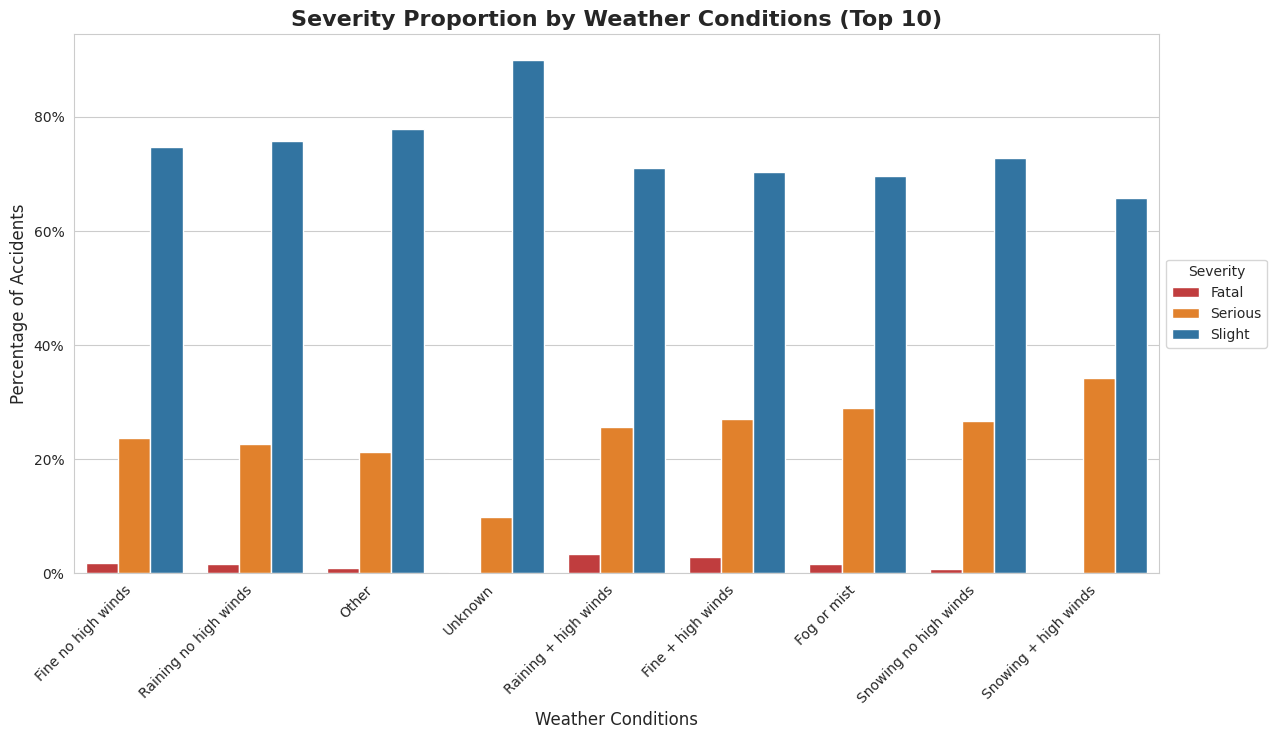

In [16]:
plot_normalized_barchart(df_eda, 'weather_conditions', 'Severity Proportion by Weather Conditions (Top 10)')


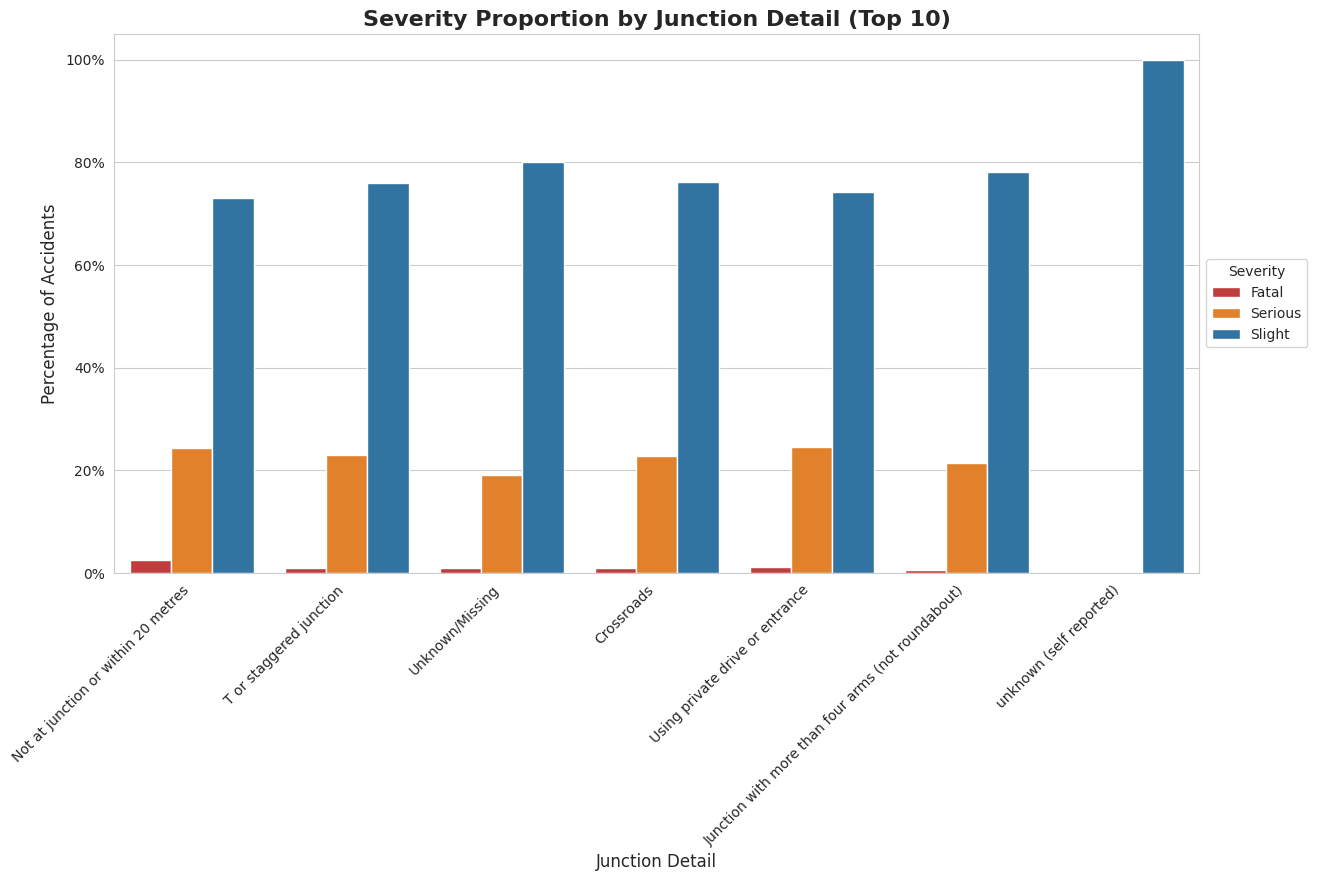

In [18]:
plot_normalized_barchart(df_eda, 'junction_detail', 'Severity Proportion by Junction Detail (Top 10)')

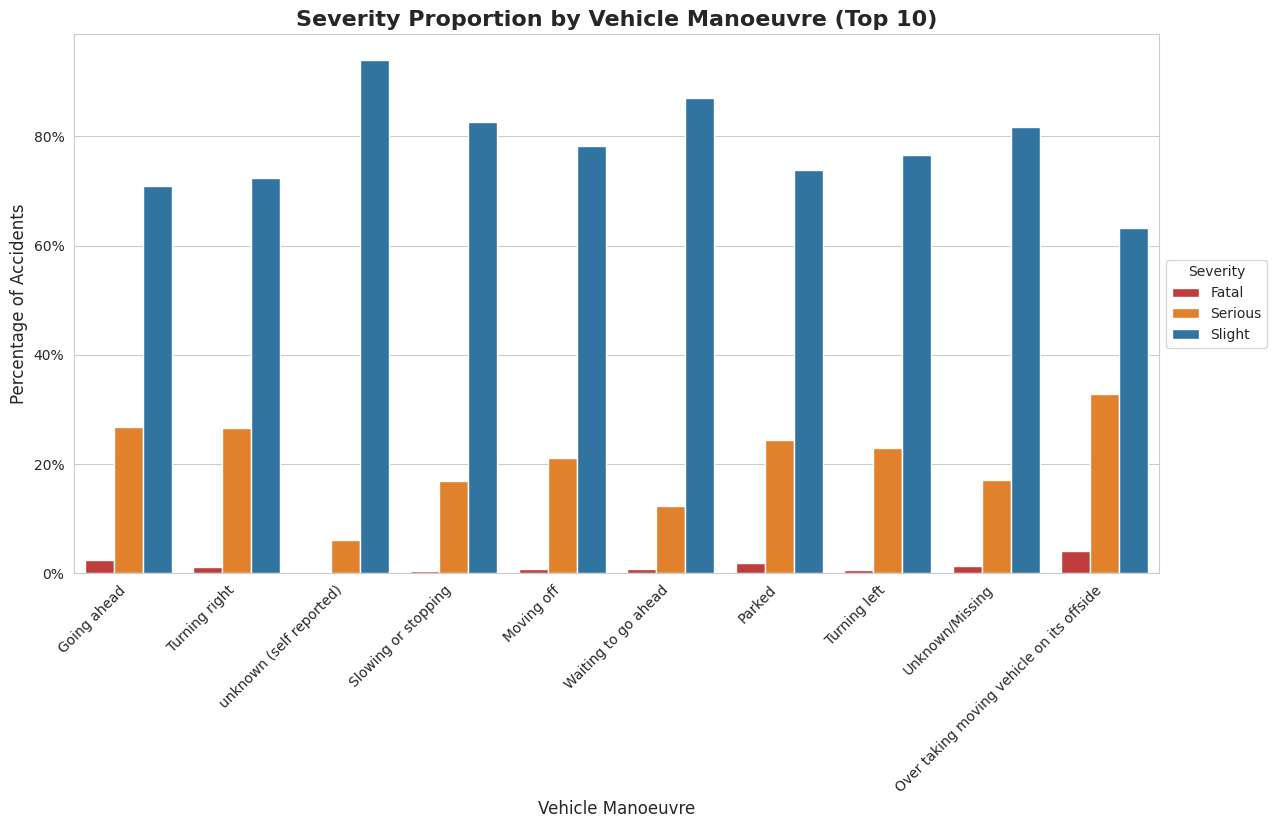

In [19]:
plot_normalized_barchart(df_eda, 'vehicle_manoeuvre', 'Severity Proportion by Vehicle Manoeuvre (Top 10)')

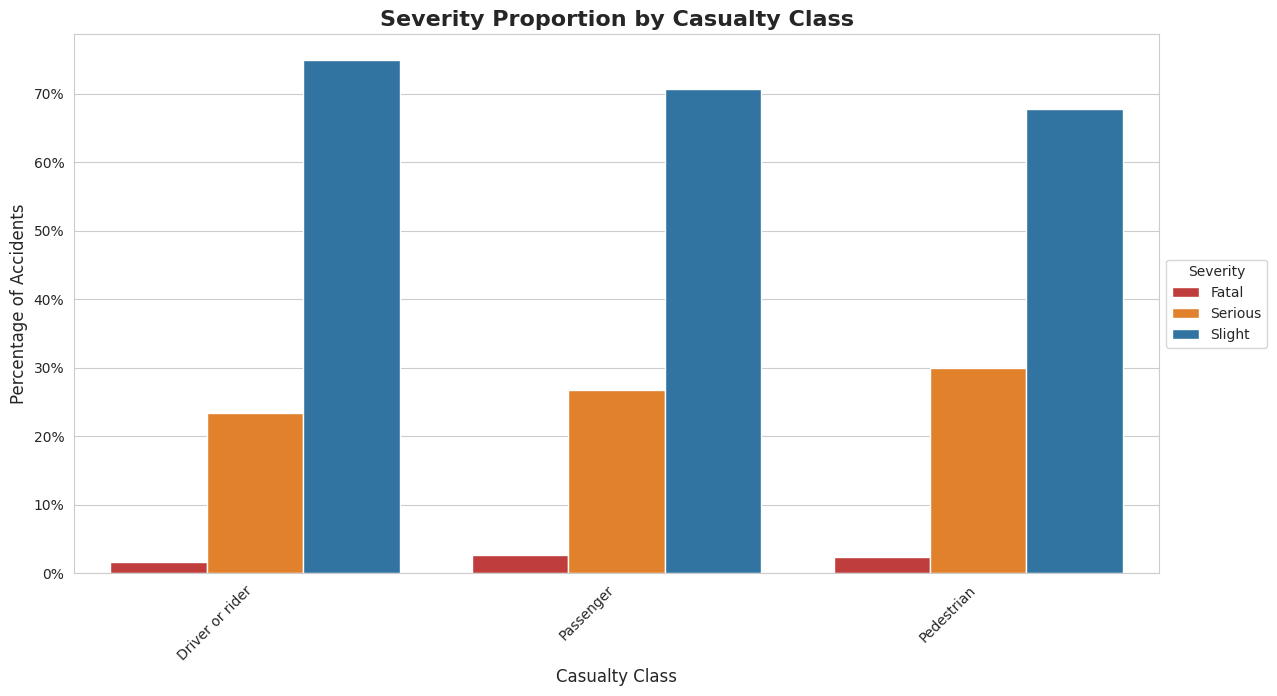

In [20]:
plot_normalized_barchart(df_eda, 'casualty_class', 'Severity Proportion by Casualty Class')

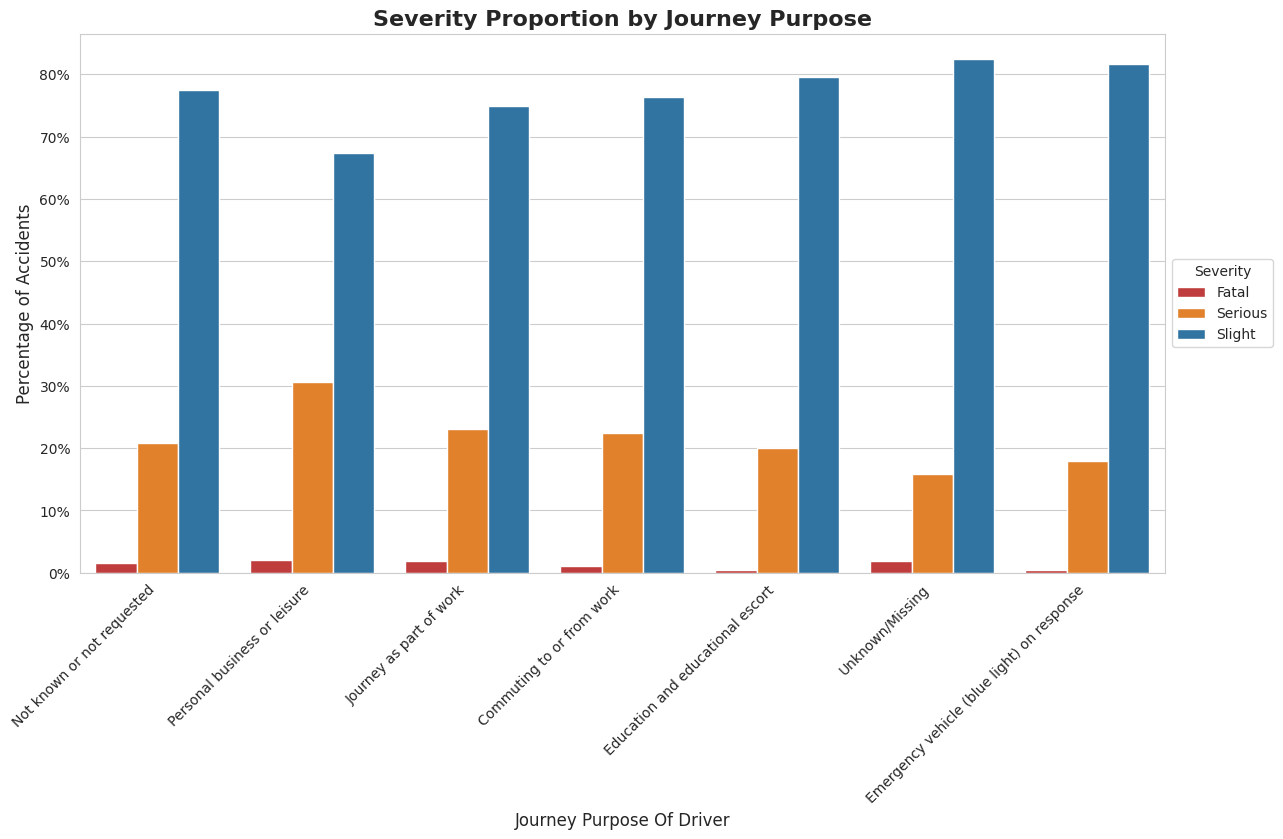

In [21]:
plot_normalized_barchart(df_eda, 'journey_purpose_of_driver', 'Severity Proportion by Journey Purpose')

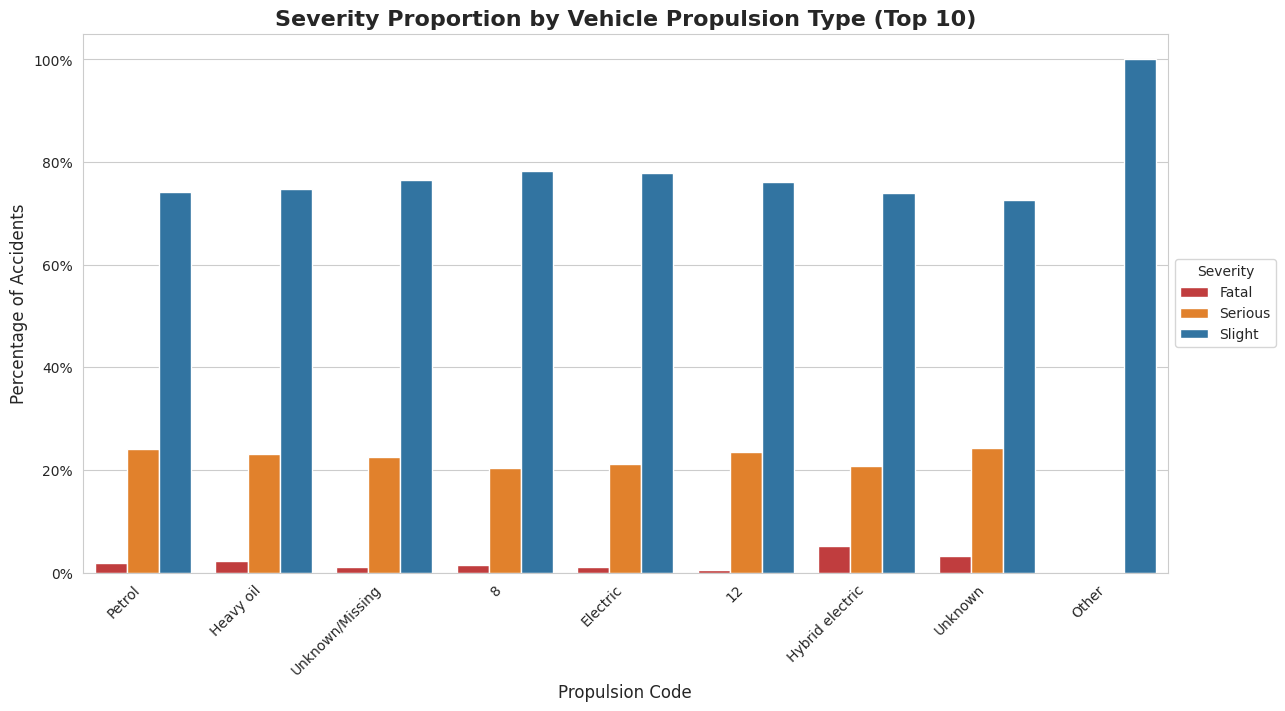

In [22]:
plot_normalized_barchart(df_eda, 'propulsion_code', 'Severity Proportion by Vehicle Propulsion Type (Top 10)')

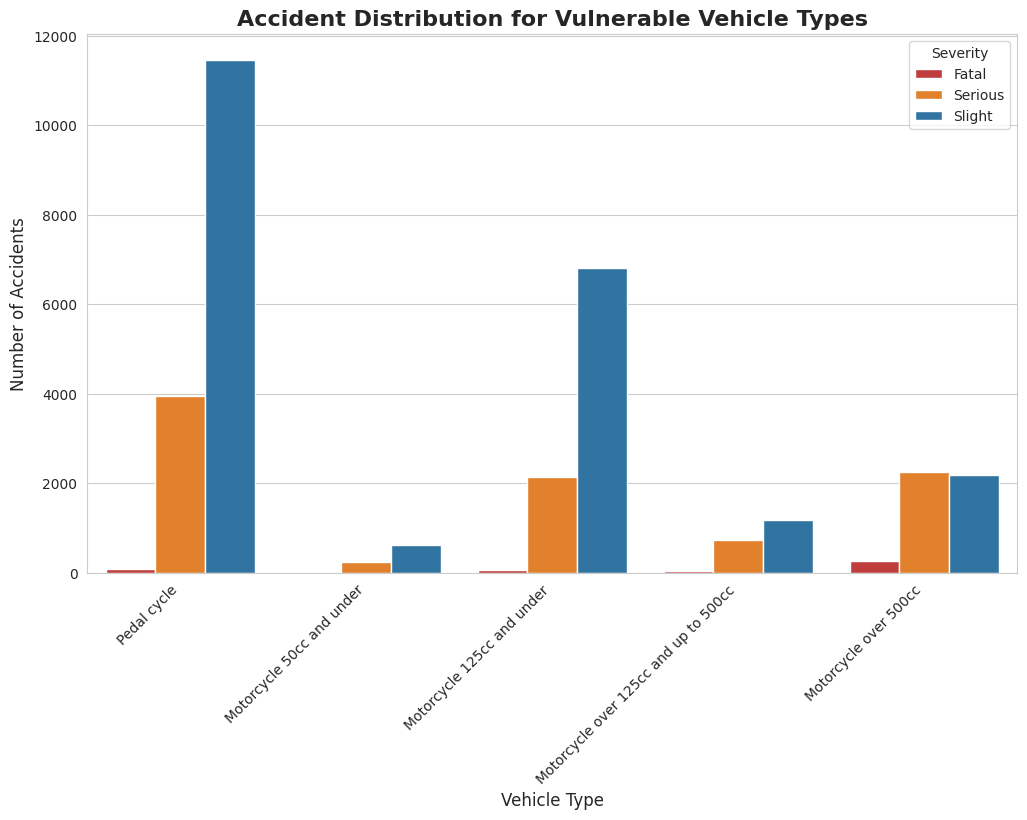

In [24]:
vulnerable_vehicles = [
    'Pedal cycle', 
    'Motorcycle 50cc and under', 
    'Motorcycle 125cc and under', 
    'Motorcycle over 125cc and up to 500cc', 
    'Motorcycle over 500cc'
]

df_vulnerable = df_eda[df_eda['vehicle_type'].isin(vulnerable_vehicles)]

plt.figure(figsize=(12, 7))
ax = sns.countplot(
    data=df_vulnerable,
    x='vehicle_type',
    hue='severity_label',
    order=vulnerable_vehicles,
    hue_order=['Fatal', 'Serious', 'Slight'],
    palette={'Fatal': '#D62728', 'Serious': '#FF7F0E', 'Slight': '#1F77B4'}
)

plt.title('Accident Distribution for Vulnerable Vehicle Types', fontsize=16, fontweight='bold')
plt.xlabel('Vehicle Type', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Severity')
plt.show()

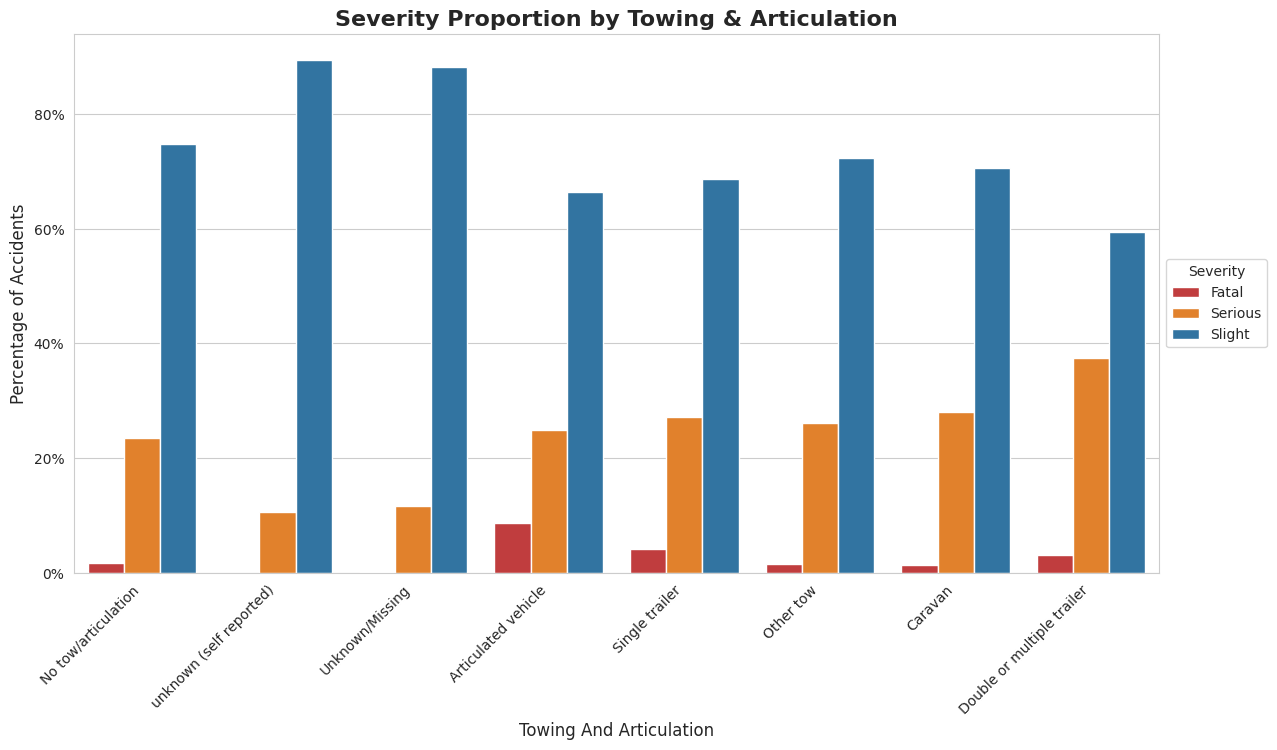

In [25]:
plot_normalized_barchart(df_eda, 'towing_and_articulation', 'Severity Proportion by Towing & Articulation')

In [33]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

features_to_profile = cluster_features

def get_mapped_value(value, feature_name):
    try:
        lookup_value = int(value)
    except (ValueError, TypeError):
        lookup_value = value 

    if feature_name in CODE_MAPPINGS_DICT:
        return CODE_MAPPINGS_DICT[feature_name].get(lookup_value, f"{value}")
    elif feature_name == 'speed_limit':
        return "Unknown" if lookup_value == -1 else f"{int(lookup_value)} mph"
    else:
        return str(value)

print("--- Cluster Personas & Severity Insights ---\n")

for cluster_id in sorted(df_cluster_raw['cluster'].unique()):
    cluster_data = df_cluster_raw[df_cluster_raw['cluster'] == cluster_id]
    
    print(f"----------------------------------------")
    print(f"Cluster {cluster_id} Persona")
    print(f"----------------------------------------")
    
    for feature in features_to_profile:
        if feature in cluster_data.columns:
            top_value_code = cluster_data[feature].mode()[0]
            top_value_percent = (cluster_data[feature] == top_value_code).mean() * 100
            top_value_name = get_mapped_value(top_value_code, feature)
            feature_title = feature.replace('_', ' ').title()
            print(f"  🔹 {feature_title}: {top_value_name} ({top_value_percent:.1f}%)")
    
    
    severity_dist = (cluster_data['severity_label'].value_counts(normalize=True) * 100).map('{:.1f}%'.format)
    severity_dist = severity_dist.to_dict()

    print(f"\n   Key Insight: Severity Profile")
    print(f"     Fatal:   {severity_dist.get('Fatal', '0.0%')}")
    print(f"     Serious: {severity_dist.get('Serious', '0.0%')}")
    print(f"     Slight:  {severity_dist.get('Slight', '0.0%')}")
    print("\n")

--- Cluster Personas & Severity Insights ---

----------------------------------------
Cluster 0 Persona
----------------------------------------
  🔹 Speed Limit: 60 mph (61.2%)
  🔹 Is Dark: True (100.0%)
  🔹 Is Poor Surface: True (50.4%)
  🔹 Is High Speed: True (100.0%)
  🔹 Urban Or Rural Area: Rural (91.7%)
  🔹 Road Type: Single carriageway (54.2%)
  🔹 Junction Detail: Not at junction or within 20 metres (78.7%)
  🔹 Vehicle Type: Car (81.4%)
  🔹 Age Band Of Driver: 26 - 30 (20.1%)
  🔹 Weather Conditions: Fine no high winds (68.7%)
  🔹 Light Conditions: Darkness - no lighting (67.2%)

   Key Insight: Severity Profile
     Fatal:   5.4%
     Serious: 29.4%
     Slight:  65.2%


----------------------------------------
Cluster 1 Persona
----------------------------------------
  🔹 Speed Limit: 30 mph (60.5%)
  🔹 Is Dark: False (100.0%)
  🔹 Is Poor Surface: False (100.0%)
  🔹 Is High Speed: False (100.0%)
  🔹 Urban Or Rural Area: Urban (78.6%)
  🔹 Road Type: Single carriageway (74.9%)
  

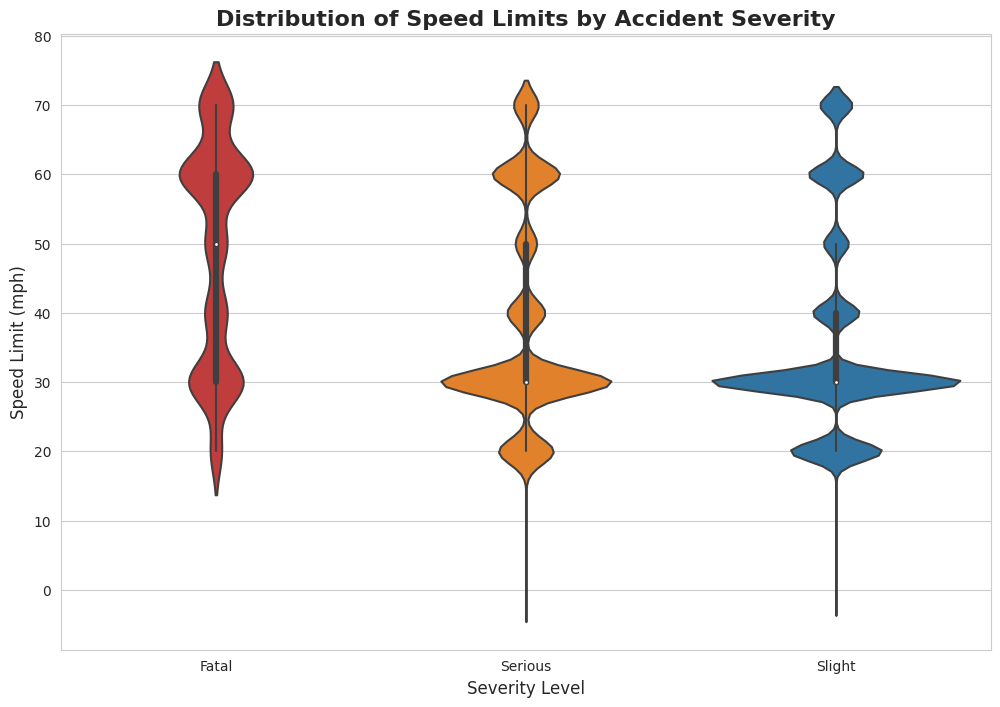

In [12]:
plt.figure(figsize=(12, 8))
sns.violinplot(
    x='severity_label',
    y='speed_limit',
    data=df_eda,
    order=['Fatal', 'Serious', 'Slight'],
    palette={'Fatal': '#D62728', 'Serious': '#FF7F0E', 'Slight': '#1F77B4'}
)

plt.title('Distribution of Speed Limits by Accident Severity', fontsize=16, fontweight='bold')
plt.xlabel('Severity Level', fontsize=12)
plt.ylabel('Speed Limit (mph)', fontsize=12)
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


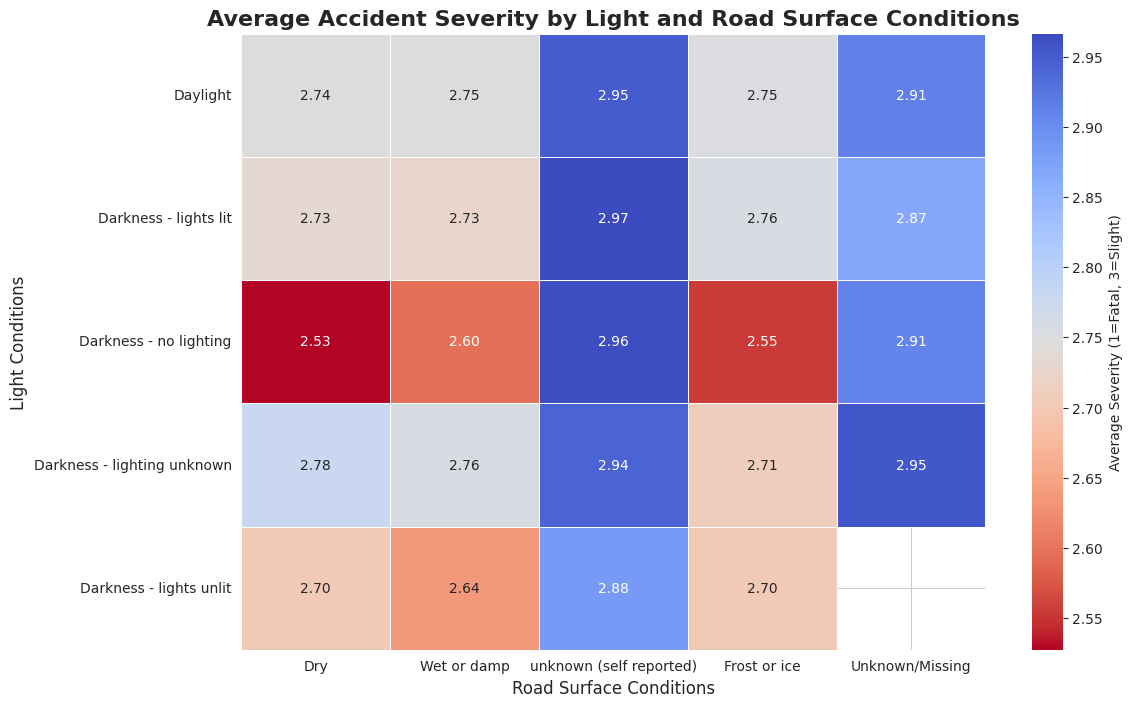

In [13]:
pivot_df = df_eda.pivot_table(
    values='collision_severity',
    index='light_conditions',
    columns='road_surface_conditions',
    aggfunc='mean'
)

top_light = df_eda['light_conditions'].value_counts().head(5).index
top_surface = df_eda['road_surface_conditions'].value_counts().head(5).index

pivot_df_filtered = pivot_df.loc[top_light, top_surface]

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_df_filtered,
    annot=True,
    fmt=".2f",
    cmap="coolwarm_r", # Reversed coolwarm: red is low (bad), blue is high (better)
    linewidths=.5,
    cbar_kws={'label': 'Average Severity (1=Fatal, 3=Slight)'}
)

plt.title('Average Accident Severity by Light and Road Surface Conditions', fontsize=16, fontweight='bold')
plt.xlabel('Road Surface Conditions', fontsize=12)
plt.ylabel('Light Conditions', fontsize=12)
plt.show()

Latitude and Longitude columns found. Plotting geo-data...


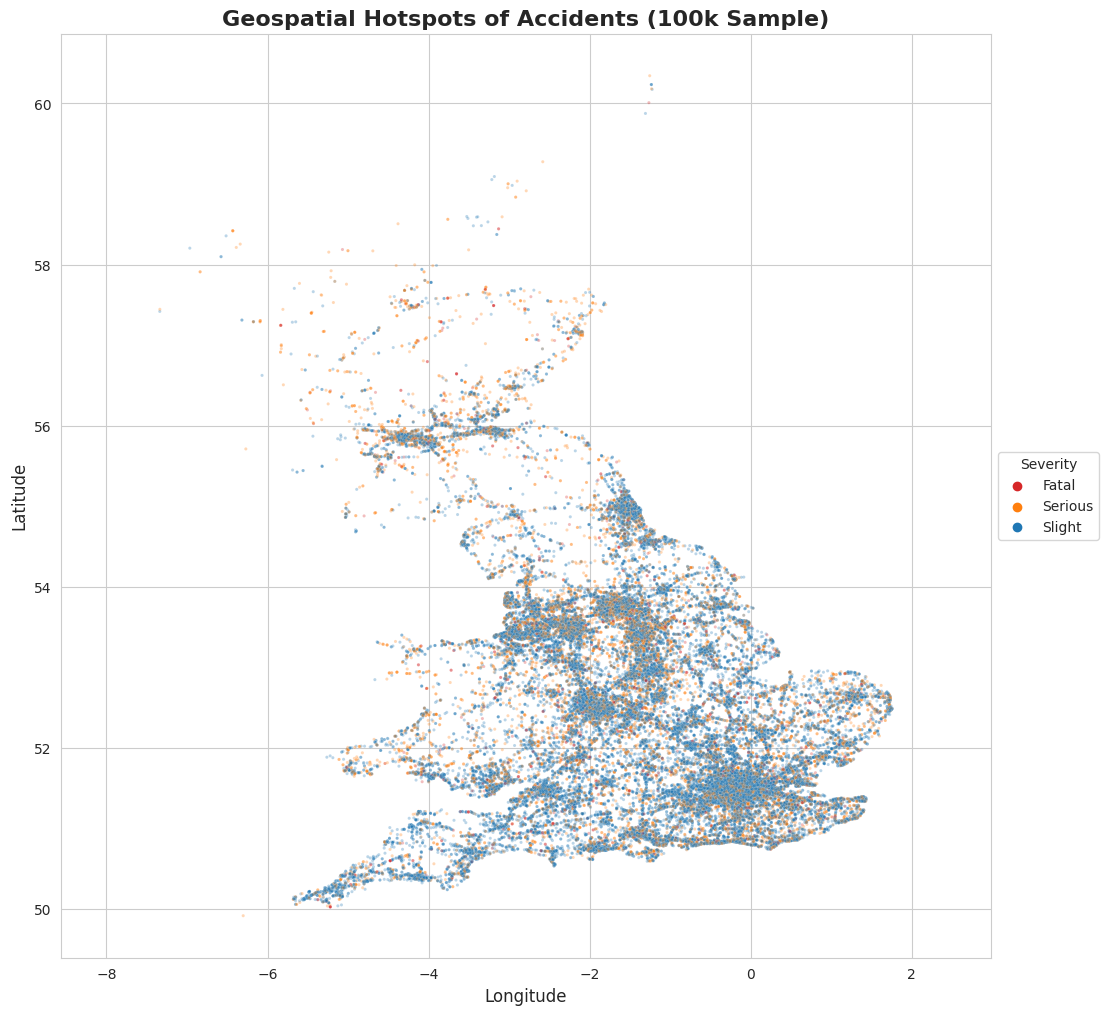

In [14]:
if 'latitude' in df_eda.columns and 'longitude' in df_eda.columns:
    print("Latitude and Longitude columns found. Plotting geo-data...")
    
    df_geo = df_eda[['latitude', 'longitude', 'severity_label']].dropna()
    
    if len(df_geo) > 100000:
        df_sample = df_geo.sample(100000, random_state=42)
    else:
        df_sample = df_geo
        
    plt.figure(figsize=(12, 12))
    sns.scatterplot(
        x='longitude',
        y='latitude',
        data=df_sample,
        hue='severity_label',
        palette={'Fatal': '#D62728', 'Serious': '#FF7F0E', 'Slight': '#1F77B4'},
        s=5, # Small point size
        alpha=0.3, # Use transparency to show density
        hue_order=['Fatal', 'Serious', 'Slight'],
        legend='full'
    )
    
    plt.title('Geospatial Hotspots of Accidents (100k Sample)', fontsize=16, fontweight='bold')
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.legend(title='Severity', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.axis('equal') # Ensure correct aspect ratio
    plt.show()

else:
    print("Could not find 'latitude' or 'longitude' columns for geospatial plot.")

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

In [2]:
import pandas as pd

if 'collision_severity' not in df.columns and 'collision_severity_y' in df.columns:
     target_col = 'collision_severity_y'
elif 'collision_severity' in df.columns:
     target_col = 'collision_severity'
else:
    raise ValueError("Target column not found in df")

y_original = df.dropna(subset=[target_col])[target_col]
y_mapping = {1: 0, 2: 1, 3: 2}
y_mapped = y_original.map(y_mapping)
mask = y_mapped.notna()

df_profile = df.dropna(subset=[target_col])[mask].copy()
df_profile['cluster'] = cluster_preds
df_profile['severity'] = y_mapped[mask]

features_to_profile = [
    'urban_or_rural_area',
    'speed_limit',
    'light_conditions',
    'vehicle_type',
    'age_band_of_driver'
]

severity_map = {0: 'Fatal', 1: 'Serious', 2: 'Slight'}

def get_mapped_value(value, feature_name):
    try:
        lookup_value = int(value)
    except (ValueError, TypeError):
        lookup_value = value

    if feature_name in CODE_MAPPINGS_DICT:
        return CODE_MAPPINGS_DICT[feature_name].get(lookup_value, f"{value}")
    elif feature_name == 'speed_limit':
        return "Unknown" if lookup_value == -1 else f"{int(lookup_value)} mph"
    else:
        return str(value)

print("--- Cluster Personas & Severity Insights ---\n")

for cluster_id in sorted(df_profile['cluster'].unique()):
    cluster_data = df_profile[df_profile['cluster'] == cluster_id]
    
    print(f"----------------------------------------")
    print(f"Cluster {cluster_id} Persona")
    print(f"----------------------------------------")
    
    for feature in features_to_profile:
        if feature in cluster_data.columns:
            top_value_code = cluster_data[feature].mode()[0]
            top_value_percent = (cluster_data[feature] == top_value_code).mean() * 100
            top_value_name = get_mapped_value(top_value_code, feature)
            feature_title = feature.replace('_', ' ').title()
            print(f"  🔹 {feature_title}: {top_value_name} ({top_value_percent:.1f}%)")
    
    
    severity_dist = (cluster_data['severity'].value_counts(normalize=True) * 100).map('{:.1f}%'.format)
    severity_dist = severity_dist.rename(index=severity_map).to_dict()

    print(f"\n   Key Insight: Severity Profile")
    print(f"     Fatal:   {severity_dist.get('Fatal', '0.0%')}")
    print(f"     Serious: {severity_dist.get('Serious', '0.0%')}")
    print(f"     Slight:  {severity_dist.get('Slight', '0.0%')}")
    print("\n")

NameError: name 'df' is not defined

In [3]:
!pip install protobuf==3.20.3 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.4 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
pydrive2 1.21.3 requires cryptograp

In [2]:
print("STARTING TASK: 2-Class (High_Severity vs Slight) - 'Smart Cleaned'")

try:
    del df_3, X_full_sparse_3, X_train_3, X_val_3, X_test_3, model_3_base, model_3_agg
    del df_5, X_full_sparse_5, X_train_5, X_val_5, X_test_5, model_5_base, model_5_agg
    del df_6, X_full_sparse_6, X_train_6, X_val_6, X_test_6, model_6_base, model_6_agg
    gc.collect()
except NameError:
    pass

df_2 = load_and_map_data()
feature_cols_2 = [c for c in REDUCED_FEATURE_COLUMNS if c in df_2.columns]

df_processed_2 = df_2[feature_cols_2].copy()
df_processed_2 = df_processed_2.replace(BAD_STRINGS, np.nan)
df_2['incident_text'] = df_processed_2.fillna("").astype(str).agg(" ".join, axis=1)

tfidf_2 = TfidfVectorizer(max_features=5000, ngram_range=(1,2), sublinear_tf=True)
X_full_sparse_2 = tfidf_2.fit_transform(df_2['incident_text'])
TEXT_INPUT_DIM_2 = X_full_sparse_2.shape[1]

y_target_2, target_names_2, original_indices_2 = create_target_data(df_2, '2-Class')

X_target_sparse_2 = X_full_sparse_2[original_indices_2]
X_train_sparse_2, X_val_test_sparse_2, y_train_2, y_val_test_2 = train_test_split(X_target_sparse_2, y_target_2, test_size=0.3, random_state=42, stratify=y_target_2)
X_val_sparse_2, X_test_sparse_2, y_val_2, y_test_2 = train_test_split(X_val_test_sparse_2, y_val_test_2, test_size=0.5, random_state=42, stratify=y_val_test_2)

X_train_2 = X_train_sparse_2.toarray()
X_val_2 = X_val_sparse_2.toarray()
X_test_2 = X_test_sparse_2.toarray()

print("Base Model (NN) - High_Severity Boost: 3.5x")
sample_weights_2_base = get_custom_weights(y_train_2, target_names_2, '2-Class-Base')
model_2_base = build_main_nn_model(TEXT_INPUT_DIM_2, len(target_names_2))
model_2_base.fit(X_train_2, y_train_2, sample_weight=sample_weights_2_base, validation_data=(X_val_2, y_val_2), epochs=50, batch_size=256, callbacks=[early_stop], verbose=0)
y_proba_base = model_2_base.predict(X_test_2, verbose=0)
y_pred_base = (y_proba_base > 0.5).astype(int)
print(classification_report(y_test_2, y_pred_base, target_names=target_names_2, digits=4, zero_division=0))

print("Optimized Model (NN) - High_Severity Boost: 4.5x")
sample_weights_2_agg = get_custom_weights(y_train_2, target_names_2, '2-Class-Aggressive')
model_2_agg = build_main_nn_model(TEXT_INPUT_DIM_2, len(target_names_2))
model_2_agg.fit(X_train_2, y_train_2, sample_weight=sample_weights_2_agg, validation_data=(X_val_2, y_val_2), epochs=50, batch_size=256, callbacks=[early_stop], verbose=0)
y_proba_agg = model_2_agg.predict(X_test_2, verbose=0)
y_pred_agg = (y_proba_agg > 0.5).astype(int)
print(classification_report(y_test_2, y_pred_agg, target_names=target_names_2, digits=4, zero_division=0))

STARTING TASK: 2-Class (High_Severity vs Slight) - 'Smart Cleaned'
Base Model (NN) - High_Severity Boost: 3.5x


I0000 00:00:1762637148.779957    4807 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762637148.780623    4807 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1762637158.226802    4846 service.cc:148] XLA service 0x7fc054006b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762637158.227472    4846 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762637158.227494    4846 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762637158.479284    4846 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762637160.032070    4846 device_compiler.h:188] Compiled clust

               precision    recall  f1-score   support

High_Severity     0.3533    0.8317    0.4959      7450
       Slight     0.9000    0.4987    0.6418     22629

     accuracy                         0.5812     30079
    macro avg     0.6266    0.6652    0.5689     30079
 weighted avg     0.7646    0.5812    0.6057     30079

Optimized Model (NN) - High_Severity Boost: 4.5x
               precision    recall  f1-score   support

High_Severity     0.3862    0.8015    0.5213      7450
       Slight     0.8988    0.5807    0.7055     22629

     accuracy                         0.6354     30079
    macro avg     0.6425    0.6911    0.6134     30079
 weighted avg     0.7719    0.6354    0.6599     30079



In [5]:
print("STARTING TASK: 3-Class (Fatal vs Serious vs Slight) - 'Smart Cleaned'")

try:
    del df_2, X_full_sparse_2, X_train_2, X_val_2, X_test_2, model_2_base, model_2_agg
    del df_5, X_full_sparse_5, X_train_5, X_val_5, X_test_5, model_5_base, model_5_agg
    del df_6, X_full_sparse_6, X_train_6, X_val_6, X_test_6, model_6_base, model_6_agg
    gc.collect()
except NameError:
    pass

df_3 = load_and_map_data()
feature_cols_3 = [c for c in REDUCED_FEATURE_COLUMNS if c in df_3.columns]

df_processed_3 = df_3[feature_cols_3].copy()
df_processed_3 = df_processed_3.replace(BAD_STRINGS, np.nan)
df_3['incident_text'] = df_processed_3.fillna("").astype(str).agg(" ".join, axis=1)

tfidf_3 = TfidfVectorizer(max_features=5000, ngram_range=(1,2), sublinear_tf=True)
X_full_sparse_3 = tfidf_3.fit_transform(df_3['incident_text'])
TEXT_INPUT_DIM_3 = X_full_sparse_3.shape[1]

y_target_3, target_names_3, original_indices_3 = create_target_data(df_3, '3-Class')

X_target_sparse_3 = X_full_sparse_3[original_indices_3]
X_train_sparse_3, X_val_test_sparse_3, y_train_3, y_val_test_3 = train_test_split(X_target_sparse_3, y_target_3, test_size=0.3, random_state=42, stratify=y_target_3)
X_val_sparse_3, X_test_sparse_3, y_val_3, y_test_3 = train_test_split(X_val_test_sparse_3, y_val_test_3, test_size=0.5, random_state=42, stratify=y_val_test_3)

X_train_3 = X_train_sparse_3.toarray()
X_val_3 = X_val_sparse_3.toarray()
X_test_3 = X_test_sparse_3.toarray()

print("Base Model (NN) - Fatal: 3.0x, Serious: 2.0x")
sample_weights_3_base = get_custom_weights(y_train_3, target_names_3, '3-Class-Base')
model_3_base = build_main_nn_model(TEXT_INPUT_DIM_3, len(target_names_3))
model_3_base.fit(X_train_3, y_train_3, sample_weight=sample_weights_3_base, validation_data=(X_val_3, y_val_3), epochs=50, batch_size=256, callbacks=[early_stop], verbose=0)
y_proba_base = model_3_base.predict(X_test_3, verbose=0)
y_pred_base = np.argmax(y_proba_base, axis=1)
print(classification_report(y_test_3, y_pred_base, target_names=target_names_3, digits=4, zero_division=0))

print("Optimized Model (NN) - Fatal: 5.0x, Serious: 3.0x")
sample_weights_3_agg = get_custom_weights(y_train_3, target_names_3, '3-Class-Aggressive')
model_3_agg = build_main_nn_model(TEXT_INPUT_DIM_3, len(target_names_3))
model_3_agg.fit(X_train_3, y_train_3, sample_weight=sample_weights_3_agg, validation_data=(X_val_3, y_val_3), epochs=50, batch_size=256, callbacks=[early_stop], verbose=0)
y_proba_agg = model_3_agg.predict(X_test_3, verbose=0)
y_pred_agg = np.argmax(y_proba_agg, axis=1)
print(classification_report(y_test_3, y_pred_agg, target_names=target_names_3, digits=4, zero_division=0))

STARTING TASK: 3-Class (Fatal vs Serious vs Slight) - 'Smart Cleaned'
Base Model (NN) - Fatal: 3.0x, Serious: 2.0x
              precision    recall  f1-score   support

       Fatal     0.3220    0.5848    0.4153       501
     Serious     0.3695    0.6949    0.4825      6949
      Slight     0.8735    0.6215    0.7262     22629

    accuracy                         0.6378     30079
   macro avg     0.5217    0.6337    0.5413     30079
weighted avg     0.7479    0.6378    0.6647     30079

Optimized Model (NN) - Fatal: 5.0x, Serious: 3.0x
              precision    recall  f1-score   support

       Fatal     0.2817    0.6128    0.3859       501
     Serious     0.3220    0.7890    0.4573      6949
      Slight     0.8920    0.4714    0.6168     22629

    accuracy                         0.5472     30079
   macro avg     0.4985    0.6244    0.4867     30079
weighted avg     0.7501    0.5472    0.5761     30079



In [2]:
print("STARTING TASK: 5-Class (F+S Merged, Risk Split) - 'Smart Cleaned'")

try:
    del df_2, X_full_sparse_2, X_train_2, X_val_2, X_test_2, model_2_base, model_2_agg
    del df_3, X_full_sparse_3, X_train_3, X_val_3, X_test_3, model_3_base, model_3_agg
    del df_6, X_full_sparse_6, X_train_6, X_val_6, X_test_6, model_6_base, model_6_agg
    gc.collect()
except NameError:
    pass

df_5 = load_and_map_data()
feature_cols_5 = [c for c in REDUCED_FEATURE_COLUMNS if c in df_5.columns]

df_processed_5 = df_5[feature_cols_5].copy()
df_processed_5 = df_processed_5.replace(BAD_STRINGS, np.nan)
df_5['incident_text'] = df_processed_5.fillna("").astype(str).agg(" ".join, axis=1)

tfidf_5 = TfidfVectorizer(max_features=5000, ngram_range=(1,2), sublinear_tf=True)
X_full_sparse_5 = tfidf_5.fit_transform(df_5['incident_text'])
TEXT_INPUT_DIM_5 = X_full_sparse_5.shape[1]

y_target_5, target_names_5, original_indices_5 = create_target_data(df_5, '5-Class')

X_target_sparse_5 = X_full_sparse_5[original_indices_5]
X_train_sparse_5, X_val_test_sparse_5, y_train_5, y_val_test_5 = train_test_split(X_target_sparse_5, y_target_5, test_size=0.3, random_state=42, stratify=y_target_5)
X_val_sparse_5, X_test_sparse_5, y_val_5, y_test_5 = train_test_split(X_val_test_sparse_5, y_val_test_5, test_size=0.5, random_state=42, stratify=y_val_test_5)

X_train_5 = X_train_sparse_5.toarray()
X_val_5 = X_val_sparse_5.toarray()
X_test_5 = X_test_sparse_5.toarray()

print("Base Model (NN) - High_Severity Boost: 3.5x")
sample_weights_5_base = get_custom_weights(y_train_5, target_names_5, '5-Class-Base')
model_5_base = build_main_nn_model(TEXT_INPUT_DIM_5, len(target_names_5))
model_5_base.fit(X_train_5, y_train_5, sample_weight=sample_weights_5_base, validation_data=(X_val_5, y_val_5), epochs=50, batch_size=256, callbacks=[early_stop], verbose=0)
y_proba_base = model_5_base.predict(X_test_5, verbose=0)
y_pred_base = np.argmax(y_proba_base, axis=1)
print(classification_report(y_test_5, y_pred_base, target_names=target_names_5, digits=4, zero_division=0))

print("Optimized Model (NN) - High_Severity Boost: 4.5x")
sample_weights_5_agg = get_custom_weights(y_train_5, target_names_5, '5-Class-Aggressive')
model_5_agg = build_main_nn_model(TEXT_INPUT_DIM_5, len(target_names_5))
model_5_agg.fit(X_train_5, y_train_5, sample_weight=sample_weights_5_agg, validation_data=(X_val_5, y_val_5), epochs=50, batch_size=256, callbacks=[early_stop], verbose=0)
y_proba_agg = model_5_agg.predict(X_test_5, verbose=0)
y_pred_agg = np.argmax(y_proba_agg, axis=1)
print(classification_report(y_test_5, y_pred_agg, target_names=target_names_5, digits=4, zero_division=0))

STARTING TASK: 5-Class (F+S Merged, Risk Split) - 'Smart Cleaned'
Base Model (NN) - High_Severity Boost: 3.5x


I0000 00:00:1762635077.953126    3130 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762635077.953787    3130 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1762635087.244471    3164 service.cc:148] XLA service 0x7c045c002b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762635087.245172    3164 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762635087.245388    3164 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762635087.468146    3164 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762635089.144092    3164 device_compiler.h:188] Compiled clust

                         precision    recall  f1-score   support

          High_Severity     0.4437    0.6146    0.5153      7450
   Slight_DARKNESS_RISK     0.8392    0.9033    0.8701      3745
  Slight_LOW_HIGH_SPEED     0.7981    0.8770    0.8357      2082
Slight_LOW_NORMAL_SPEED     0.8851    0.6232    0.7314     10951
    Slight_SURFACE_RISK     0.8471    0.8293    0.8381      5851

               accuracy                         0.7136     30079
              macro avg     0.7626    0.7695    0.7581     30079
           weighted avg     0.7566    0.7136    0.7231     30079

Optimized Model (NN) - High_Severity Boost: 4.5x
                         precision    recall  f1-score   support

          High_Severity     0.4290    0.6219    0.5078      7450
   Slight_DARKNESS_RISK     0.8316    0.8913    0.8604      3745
  Slight_LOW_HIGH_SPEED     0.8130    0.8564    0.8342      2082
Slight_LOW_NORMAL_SPEED     0.8785    0.6125    0.7218     10951
    Slight_SURFACE_RISK     0.8518   

In [3]:
print("STARTING TASK: 6-Class (F/S Separated, Risk Split) - 'Smart Cleaned'")

try:
    del df_2, X_full_sparse_2, X_train_2, X_val_2, X_test_2, model_2_base, model_2_agg
    del df_3, X_full_sparse_3, X_train_3, X_val_3, X_test_3, model_3_base, model_3_agg
    del df_5, X_full_sparse_5, X_train_5, X_val_5, X_test_5, model_5_base, model_5_agg
    gc.collect()
except NameError:
    pass

df_6 = load_and_map_data()
feature_cols_6 = [c for c in REDUCED_FEATURE_COLUMNS if c in df_6.columns]

df_processed_6 = df_6[feature_cols_6].copy()
df_processed_6 = df_processed_6.replace(BAD_STRINGS, np.nan)
df_6['incident_text'] = df_processed_6.fillna("").astype(str).agg(" ".join, axis=1)

tfidf_6 = TfidfVectorizer(max_features=5000, ngram_range=(1,2), sublinear_tf=True)
X_full_sparse_6 = tfidf_6.fit_transform(df_6['incident_text'])
TEXT_INPUT_DIM_6 = X_full_sparse_6.shape[1]

y_target_6, target_names_6, original_indices_6 = create_target_data(df_6, '6-Class')

X_target_sparse_6 = X_full_sparse_6[original_indices_6]
X_train_sparse_6, X_val_test_sparse_6, y_train_6, y_val_test_6 = train_test_split(X_target_sparse_6, y_target_6, test_size=0.3, random_state=42, stratify=y_target_6)
X_val_sparse_6, X_test_sparse_6, y_val_6, y_test_6 = train_test_split(X_val_test_sparse_6, y_val_test_6, test_size=0.5, random_state=42, stratify=y_val_test_6)

X_train_6 = X_train_sparse_6.toarray()
X_val_6 = X_val_sparse_6.toarray()
X_test_6 = X_test_sparse_6.toarray()

print("Base Model (NN) - Fatal: 0.55x, Serious: 2.0x")
sample_weights_6_base = get_custom_weights(y_train_6, target_names_6, '6-Class-Base')
model_6_base = build_main_nn_model(TEXT_INPUT_DIM_6, len(target_names_6))
model_6_base.fit(X_train_6, y_train_6, sample_weight=sample_weights_6_base, validation_data=(X_val_6, y_val_6), epochs=50, batch_size=256, callbacks=[early_stop], verbose=0)
y_proba_base = model_6_base.predict(X_test_6, verbose=0)
y_pred_base = np.argmax(y_proba_base, axis=1)
print(classification_report(y_test_6, y_pred_base, target_names=target_names_6, digits=4, zero_division=0))

print("Optimized Model (NN) - Fatal: 1.0x, Serious: 3.0x")
sample_weights_6_agg = get_custom_weights(y_train_6, target_names_6, '6-Class-Aggressive')
model_6_agg = build_main_nn_model(TEXT_INPUT_DIM_6, len(target_names_6))
model_6_agg.fit(X_train_6, y_train_6, sample_weight=sample_weights_6_agg, validation_data=(X_val_6, y_val_6), epochs=50, batch_size=256, callbacks=[early_stop], verbose=0)
y_proba_agg = model_6_agg.predict(X_test_6, verbose=0)
y_pred_agg = np.argmax(y_proba_agg, axis=1)
print(classification_report(y_test_6, y_pred_agg, target_names=target_names_6, digits=4, zero_division=0))

STARTING TASK: 6-Class (F/S Separated, Risk Split) - 'Smart Cleaned'
Base Model (NN) - Fatal: 0.55x, Serious: 2.0x
                              precision    recall  f1-score   support

                       Fatal     0.4791    0.5040    0.4912       500
                     Serious     0.4715    0.3769    0.4189      6949
        Slight_DARKNESS_RISK     0.8133    0.9234    0.8649      3746
  Slight_LOW_RISK_HIGH_SPEED     0.7584    0.9289    0.8351      2082
Slight_LOW_RISK_NORMAL_SPEED     0.8407    0.8100    0.8250     10951
         Slight_SURFACE_RISK     0.8043    0.9133    0.8554      5851

                    accuracy                         0.7473     30079
                   macro avg     0.6946    0.7428    0.7151     30079
                weighted avg     0.7332    0.7473    0.7372     30079

Optimized Model (NN) - Fatal: 1.0x, Serious: 3.0x
                              precision    recall  f1-score   support

                       Fatal     0.4991    0.5260    0.5122  

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_score, recall_score
from scipy.sparse import csr_matrix
from tensorflow.keras.callbacks import EarlyStopping
import io
import gc

tf.get_logger().setLevel('ERROR')

CODE_MAPPINGS_DICT = {
    "day_of_week": {1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday", 5: "Thursday", 6: "Friday", 7: "Saturday", -1: "Unknown/Missing", 99: "Unknown"},
    "first_road_class": {1: "Motorway", 2: "A(M)", 3: "A", 4: "B", 5: "C", 6: "Unclassified", -1: "Unknown/Missing", 99: "Unknown"},
    "road_type": {1: "Roundabout", 2: "One way street", 3: "Dual carriageway", 6: "Single carriageway", 7: "Slip road", 9: "Unknown", 12: "One way street/Slip road", -1: "Unknown/Missing", 99: "Unknown"},
    "junction_detail": {0: "Not at junction or within 20 metres", 13: "T or staggered junction", 16: "Crossroads", 17: "Junction with more than four arms (not roundabout)", 18: "Using private drive or entrance", 99: "unknown (self reported)", -1: "Unknown/Missing"},
    "junction_control": {0: "Not at junction or within 20 metres", 1: "Authorised person", 2: "Auto traffic signal", 3: "Stop sign", 4: "Give way or uncontrolled", -1: "Unknown/Missing", 9: "unknown (self reported)", 99: "Unknown"},
    "second_road_class": {0: "Not at junction or within 20 metres", 1: "Motorway", 2: "A(M)", 3: "A", 4: "B", 5: "C", 6: "Unclassified", 9: "Unknown (self rep only)", -1: "Unknown/Missing", 99: "Unknown"},
    "pedestrian_crossing": {0: "No physical crossing facility within 50m", 11: "Human crossing control by school crossing patrol", 12: "Human crossing control by other authorised person", 13: "Zebra crossing", 14: "Pedestrian light crossing (pelican or puffin or toucan or similar)", 15: "Pedestrian phase at traffic signal", 16: "Footbridge or subway", 17: "Central refuge - no other controls", 99: "unknown (self reported)", -1: "Unknown/Missing"},
    "light_conditions": {1: "Daylight", 4: "Darkness - lights lit", 5: "Darkness - lights unlit", 6: "Darkness - no lighting", 7: "Darkness - lighting unknown", -1: "Unknown/Missing", 99: "Unknown"},
    "weather_conditions": {1: "Fine no high winds", 2: "Raining no high winds", 3: "Snowing no high winds", 4: "Fine + high winds", 5: "Raining + high winds", 6: "Snowing + high winds", 7: "Fog or mist", 8: "Other", 9: "Unknown", -1: "Unknown/Missing", 99: "Unknown"},
    "road_surface_conditions": {1: "Dry", 2: "Wet or damp", 3: "Snow", 4: "Frost or ice", 5: "Flood over 3cm. deep", 6: "Oil or diesel", 7: "Mud", -1: "Unknown/Missing", 9: "unknown (self reported)", 99: "Unknown"},
    "special_conditions_at_site": {0: "None", 1: "Auto traffic signal - out", 2: "Auto signal part defective", 3: "Road sign or marking defective or obscured", 4: "Roadworks", 5: "Road surface defective", 6: "Oil or diesel", 7: "Mud", -1: "Unknown/Missing", 9: "unknown (self reported)", 99: "Unknown"},
    "carriageway_hazards": {0: "None", 11: "Defective traffic signals", 12: "Permanent road signing or markings defective or obscured or inadequate", 13: "Roadworks", 14: "Oil or diesel", 15: "Mud", 16: "Dislodged vehicle load in carriageway", 17: "Other object in carriageway", 18: "Involvement with previous collision", 19: "Pedestrian in carriageway - not injured", 20: "Any animal in carriageway (except ridden horse)", 21: "Poor or defective road surface", -1: "Unknown/Missing", 99: "unknown (self reported)"},
    "urban_or_rural_area": {1: "Urban", 2: "Rural", 3: "Unallocated", -1: "Unknown/Missing", 99: "Unknown"},
    "vehicle_type": {1: "Pedal cycle", 2: "Motorcycle 50cc and under", 3: "Motorcycle 125cc and under", 4: "Motorcycle over 125cc and up to 500cc", 5: "Motorcycle over 500cc", 8: "Taxi/Private hire car", 9: "Car", 10: "Minibus (8 - 16 passenger seats)", 11: "Bus or coach (17 or more pass seats)", 16: "Ridden horse", 17: "Agricultural vehicle", 18: "Tram", 19: "Van / Goods 3.5 tonnes mgw or under", 20: "Goods over 3.5t. and under 7.5t", 21: "Goods 7.5 tonnes mgw and over", 22: "Mobility scooter", 23: "Electric motorcycle", 90: "Other vehicle", 97: "Motorcycle - unknown cc", 98: "Goods vehicle - unknown weight", 99: "Unknown vehicle type (self rep only)", -1: "Unknown/Missing"},
    "towing_and_articulation": {0: "No tow/articulation", 1: "Articulated vehicle", 2: "Double or multiple trailer", 3: "Caravan", 4: "Single trailer", 5: "Other tow", 9: "unknown (self reported)", -1: "Unknown/Missing", 99: "Unknown"},
    "vehicle_manoeuvre": {1: "Reversing", 2: "Parked", 3: "Waiting to go ahead", 4: "Slowing or stopping", 5: "Moving off", 6: "U-turn", 7: "Turning left", 8: "Waiting to turn left", 9: "Turning right", 10: "Waiting to turn right", 11: "Changing lane to left", 12: "Changing lane to right", 13: "Over taking moving vehicle on its offside", 14: "Overtaking stationary vehicle on its offside", 15: "Overtaking on nearside (passengers side nearest kerb)", 19: "Going ahead", 20: "Parking", 99: "unknown (self reported)", -1: "Unknown/Missing"},
    "vehicle_location_restricted_lane": {0: "On main carriageway (not in restricted lane)", 1: "Tram or Light rail track", 2: "Bus lane or Busway", 4: "Cycle lane (on main carriageway)", 5: "Cycleway or shared use footway (not part of main carriageway)", 6: "Lay-by or hard shoulder", 9: "Footway (pavement)", 99: "unknown (self reported)", -1: "Unknown/Missing"},
    "junction_location": {0: "Not at or within 20 metres of junction", 1: "Approaching junction or waiting/parked at junction approach", 2: "Cleared junction or waiting/parked at junction exit", 3: "Leaving roundabout", 4: "Entering roundabout", 5: "Leaving main road", 6: "Entering main road", 7: "Entering from slip road", 8: "Mid Junction - on roundabout or on main road", 9: "unknown (self reported)", -1: "Unknown/Missing", 99: "Unknown"},
    "vehicle_left_hand_drive": {1: "No", 2: "Yes", 9: "Unknown", -1: "Unknown/Missing", 99: "Unknown"},
    "journey_purpose_of_driver": {1: "Journey as part of work", 2: "Commuting to or from work", 6: "Not known or not requested", 7: "Education and educational escort", 8: "Emergency vehicle (blue light) on response", 9: "Personal business or leisure", -1: "Unknown/Missing", 99: "Unknown"},
    "sex_of_driver": {1: "Male", 2: "Female", 3: "Not known", -1: "Unknown/Missing", 99: "Unknown"},
    "age_band_of_driver": {1: "0 - 5", 2: "6 - 10", 3: "11 - 15", 4: "16 - 20", 5: "21 - 25", 6: "26 - 30", 7: "31 - 35", 8: "36 - 40", 9: "41 - 45", 10: "46 - 50", 11: "51 - 55", 12: "56 - 60", 13: "61 - 65", 14: "66 - 70", 15: "71+", -1: "Unknown/Missing", 99: "Unknown"},
    "propulsion_code": {1: "Petrol", 2: "Heavy oil", 3: "Electric", 4: "Gas", 5: "Hybrid electric", 6: "Other", 7: "Unknown", 99: "Unknown", -1: "Unknown/Missing"},
    "driver_imd_decile": {1: "1 (Most deprived)", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9", 10: "10 (Least deprived)", -1: "Unknown/Missing", 99: "Unknown"},
    "escooter_flag": {0: "No", 1: "Yes", 99: "Unknown", -1: "Unknown/Missing"},
    "driver_distance_banding": {1: "0-1 miles", 2: "1-2 miles", 3: "2-5 miles", 4: "5-10 miles", 5: "10-25 miles", 6: "25-50 miles", 7: "50+ miles", 9: "Unknown", -1: "Unknown/Missing", 99: "Unknown"},
    "junction_detail_historic": {0: "Not at junction or within 20 metres", 1: "Roundabout", 2: "Mini-roundabout", 3: "T or staggered junction", 5: "Slip road junction", 6: "Crossroads", 7: "Junction with more than 4 arms (not roundabout)", 18: "Using private drive or entrance", 99: "unknown (self reported)", -1: "Unknown/Missing"},
    "pedestrian_crossing_human_control_historic": {0: "No human control within 50 metres", 1: "Control by school crossing patrol", 2: "Control by other authorised person", -1: "Unknown/Missing", 99: "Unknown"},
    "pedestrian_crossing_physical_facilities_historic": {0: "No physical crossing facilities within 50 metres", 1: "Zebra crossing", 4: "Pelican, puffin or toucan light crossing", 5: "Light controlled crossing (other than above)", 6: "Footbridge or subway", 7: "Central refuge", 8: "Other physical crossing facility", -1: "Unknown/Missing", 99: "Unknown"},
    "carriageway_hazards_historic": {0: "None", 1: "Previous accident", 2: "Other non-fixed object on road", 3: "Involvement with previous accident", 4: "Dislodged vehicle load in carriageway", 5: "Any animal in carriageway (except ridden horse)", 6: "Broken down vehicle (other than involved in the accident)", 7: "Other object in carriageway", -1: "Unknown/Missing", 99: "Unknown"},
    "vehicle_manoeuvre_historic": {1: "Reversing", 2: "Parked", 3: "Waiting to go ahead", 4: "Slowing or stopping", 5: "Moving off", 6: "U-turn", 7: "Turning left", 8: "Waiting to turn left", 9: "Turning right", 10: "Waiting to turn right", 11: "Changing lane to left", 12: "Changing lane to right", 13: "Over taking moving vehicle on its offside", 14: "Overtaking stationary vehicle on its offside", 15: "Overtaking on nearside (passengers side nearest kerb)", 19: "Going ahead", 20: "Parking", 99: "unknown (self reported)", -1: "Unknown/Missing"},
    "vehicle_location_restricted_lane_historic": {0: "On main carriageway (not in restricted lane)", 1: "Tram or Light rail track", 2: "Bus lane or Busway", 4: "Cycle lane (on main carriageway)", 5: "Cycleway or shared use footway (not part of main carriageway)", 6: "Lay-by or hard shoulder", 9: "Footway (pavement)", 99: "unknown (self reported)", -1: "Unknown/Missing"},
    "journey_purpose_of_driver_historic": {1: "Journey as part of work", 2: "Commuting to or from work", 6: "Not known or not requested", 7: "Education and educational escort", 8: "Emergency vehicle (blue light) on response", 9: "Personal business or leisure", -1: "Unknown/Missing", 99: "Unknown"},
    "casualty_class": {1: "Driver or rider", 2: "Passenger", 3: "Pedestrian", -1: "Unknown/Missing", 9: "Unknown (self reported)", 99: "Unknown"},
    "sex_of_casualty": {1: "Male", 2: "Female", 3: "Not known", -1: "Unknown/Missing", 99: "Unknown"},
    "age_band_of_casualty": {1: "0 - 5", 2: "6 - 10", 3: "11 - 15", 4: "16 - 20", 5: "21 - 25", 6: "26 - 30", 7: "31 - 35", 8: "36 - 40", 9: "41 - 45", 10: "46 - 50", 11: "51 - 55", 12: "56 - 60", 13: "61 - 65", 14: "66 - 70", 15: "71+", -1: "Unknown/Missing", 99: "Unknown"},
}
for k in list(CODE_MAPPINGS_DICT.keys()):
    if 'coll' in k or 'veh' in k or 'cas' in k:
        base_k = k.split('_coll')[0].split('_veh')[0].split('_cas')[0]
        if base_k not in CODE_MAPPINGS_DICT:
            CODE_MAPPINGS_DICT[base_k] = CODE_MAPPINGS_DICT[k]

BAD_STRINGS = ["Unknown", "Unknown/Missing", "unknown (self reported)", "Unknown (self rep only)"]
REDUCED_FEATURE_COLUMNS = [
    'day_of_week', 'time', 'urban_or_rural_area', 'speed_limit', 'first_road_class', 'road_type',
    'junction_detail', 'junction_control', 'second_road_class', 'pedestrian_crossing', 'trunk_road_flag',
    'light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site',
    'junction_location', 'carriageway_hazards', 'junction_detail_historic', 
    'pedestrian_crossing_human_control_historic', 'pedestrian_crossing_physical_facilities_historic',
    'carriageway_hazards_historic', 'vehicle_type', 'towing_and_articulation', 'vehicle_manoeuvre',
    'vehicle_manoeuvre_historic', 'vehicle_location_restricted_lane', 'vehicle_left_hand_drive', 
    'journey_purpose_of_driver', 'sex_of_driver', 'age_band_of_driver', 'propulsion_code', 
    'driver_imd_decile', 'escooter_flag', 'driver_distance_banding'
]


def load_and_map_data():
    collision_path = "/kaggle/input/uk-accident-data-set-2024/dft-road-casualty-statistics-collision-2024.csv"
    vehicle_path   = "/kaggle/input/uk-accident-data-set-2024/dft-road-casualty-statistics-vehicle-2024.csv"
    casualty_path  = "/kaggle/input/uk-accident-data-set-2024/dft-road-casualty-statistics-casualty-2024.csv"
    try:
        df_collision = pd.read_csv(collision_path, low_memory=False)
        df_vehicle   = pd.read_csv(vehicle_path, low_memory=False)
        df_casualty  = pd.read_csv(casualty_path, low_memory=False)
    except FileNotFoundError:
        print("Warning: Data files not found. Creating dummy data to proceed.")
        data = {'collision_index': [1,2,3,4,5], 'collision_severity': [1, 2, 3, 3, 2], 'light_conditions': [1, 4, 1, 5, 4], 'road_surface_conditions': [1, 2, 1, 4, 2], 'speed_limit': [30, 60, 30, 70, 40], 'vehicle_reference': [1, 1, 1, 1, 1], 'day_of_week': [2, 3, 4, 5, 6]}
        df_collision = pd.DataFrame(data)
        df_vehicle = pd.DataFrame({'collision_index': [1,2,3,4,5], 'vehicle_reference': [1, 1, 1, 1, 1], 'vehicle_type': [9, 9, 1, 9, 1]})
        df_casualty = pd.DataFrame({'collision_index': [1,2,3,4,5], 'vehicle_reference': [1, 1, 1, 1, 1], 'casualty_class': [1, 2, 3, 1, 2]})

    for df_ in [df_collision, df_vehicle, df_casualty]:
        df_.columns = df_.columns.str.lower().str.strip().str.replace(' ', '_')
    key = 'collision_index' if 'collision_index' in df_collision.columns else 'accident_index'
    df = df_collision.merge(df_vehicle, on=key, how='left', suffixes=('_coll', '_veh'))
    df = df.merge(df_casualty, left_on=[key, 'vehicle_reference'], right_on=[key, 'vehicle_reference'], how='left', suffixes=('', '_cas'))
    df = df.dropna(subset=['collision_severity', 'light_conditions', 'road_surface_conditions', 'speed_limit']).copy()
    df['collision_severity'] = pd.to_numeric(df['collision_severity'], errors='coerce', downcast='integer')
    df['speed_limit'] = pd.to_numeric(df['speed_limit'], errors='coerce', downcast='integer').fillna(0)
    df = df[df['collision_severity'].isin([1, 2, 3])].reset_index(drop=True)
    
    for col in df.columns:
        col_key = col.split('_coll')[0].split('_veh')[0].split('_cas')[0]
        if col_key in CODE_MAPPINGS_DICT:
            mapping = CODE_MAPPINGS_DICT[col_key]
            if pd.api.types.is_numeric_dtype(df[col]):
                 df[col] = df[col].map(mapping).fillna(df[col])
    return df

def create_3_class_target(df_in):
    df_temp = df_in.copy()
    df_temp['target'] = df_temp['collision_severity'].map({1: 'Fatal', 2: 'Serious', 3: 'Slight'})
    df_temp = df_temp.dropna(subset=['target'])
    le = LabelEncoder()
    y = le.fit_transform(df_temp['target'])
    return y, le.classes_, df_temp.index.values

def get_custom_weights_3_class(y_train, target_names, fatal_boost, serious_boost):
    classes, class_counts = np.unique(y_train, return_counts=True)
    weights = len(y_train) / (len(classes) * class_counts)
    weight_dict = {i: weight for i, weight in enumerate(weights)}
    le = LabelEncoder().fit(target_names)
    
    if 'Fatal' in target_names:
        weight_dict[le.transform(['Fatal'])[0]] *= fatal_boost
    if 'Serious' in target_names:
        weight_dict[le.transform(['Serious'])[0]] *= serious_boost
    return np.array([weight_dict.get(label, 1.0) for label in y_train])

def build_main_nn_model(text_input_dim, output_dim):
    is_binary = output_dim == 2
    loss_fn = 'binary_crossentropy' if is_binary else 'sparse_categorical_crossentropy'
    activation = 'sigmoid' if is_binary else 'softmax'
    output_neurons = 1 if is_binary else output_dim

    text_input = Input(shape=(text_input_dim,), name='text_input')
    x = Dense(512, activation='relu')(text_input)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    output = Dense(output_neurons, activation=activation, name='output')(x)
    
    model = Model(inputs=text_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.002), loss=loss_fn, metrics=['accuracy'])
    return model

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

df_model = load_and_map_data()
feature_cols = [c for c in REDUCED_FEATURE_COLUMNS if c in df_model.columns]

df_processed = df_model[feature_cols].copy()
df_processed = df_processed.replace(BAD_STRINGS, np.nan)
df_model['incident_text'] = df_processed.fillna("").astype(str).agg(" ".join, axis=1)

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), sublinear_tf=True)
X_full_sparse = tfidf.fit_transform(df_model['incident_text'])
TEXT_INPUT_DIM = X_full_sparse.shape[1]

y_target, target_names, original_indices = create_3_class_target(df_model)

X_target_sparse = X_full_sparse[original_indices]
X_train_sparse, X_val_test_sparse, y_train, y_val_test = train_test_split(X_target_sparse, y_target, test_size=0.3, random_state=42, stratify=y_target)
X_val_sparse, X_test_sparse, y_val, y_test = train_test_split(X_val_test_sparse, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test)

X_train = X_train_sparse.toarray()
X_val = X_val_sparse.toarray()
X_test = X_test_sparse.toarray()

sample_weights = get_custom_weights_3_class(y_train, target_names, fatal_boost=3.0, serious_boost=2.0)

model = build_main_nn_model(TEXT_INPUT_DIM, len(target_names))
model.fit(X_train, y_train, sample_weight=sample_weights, validation_data=(X_val, y_val), epochs=50, batch_size=256, callbacks=[early_stop], verbose=0)

y_proba = model.predict(X_test, verbose=0)

le = LabelEncoder()
le.fit(target_names)
fatal_index = le.transform(['Fatal'])[0]
serious_index = le.transform(['Serious'])[0] 

results_df = pd.DataFrame(y_proba, columns=target_names)
results_df['True_Label'] = le.inverse_transform(y_test)

def get_new_risk_level(probabilities, fatal_idx, serious_idx, red_threshold, yellow_threshold):
    prob_fatal = probabilities[fatal_idx]
    prob_serious = probabilities[serious_idx]
    
    if prob_fatal >= red_threshold:
        return "RED ALERT"
    elif (prob_fatal + prob_serious) >= yellow_threshold:
        return "YELLOW ALERT"
    else:
        return "GREEN"

RED_THRESHOLD = 0.40 
YELLOW_THRESHOLDS = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

y_true = results_df['True_Label']
all_fatal_or_serious = (y_true == 'Fatal') | (y_true == 'Serious')
all_slight = (y_true == 'Slight')
total_fatal_or_serious = all_fatal_or_serious.sum()
total_slight = all_slight.sum()

print("\n--- Testing Alert System Thresholds ---")
print(f"RED ALERT Threshold (Fatal Prob): > {RED_THRESHOLD*100}%")

best_recall = -1
best_threshold = -1

for yellow_thresh in YELLOW_THRESHOLDS:
    results_df['Risk_Level'] = results_df.apply(
        lambda row: get_new_risk_level(row[target_names].values, fatal_index, serious_index, RED_THRESHOLD, yellow_thresh), 
        axis=1
    )
    
    predicted_red = (results_df['Risk_Level'] == 'RED ALERT')
    predicted_yellow = (results_df['Risk_Level'] == 'YELLOW ALERT')
    predicted_green = (results_df['Risk_Level'] == 'GREEN')
    predicted_any_alert = (predicted_red | predicted_yellow)

    true_pos_any_alert = (all_fatal_or_serious & predicted_any_alert).sum()
    
    high_risk_recall = true_pos_any_alert / total_fatal_or_serious
    slight_safety_rate = (all_slight & predicted_green).sum() / total_slight
    
    if high_risk_recall > best_recall:
        best_recall = high_risk_recall
        best_threshold = yellow_thresh

    print(f"  YELLOW Threshold (Fatal+Serious Prob): > {yellow_thresh*100:.0f}%  |  High-Risk Recall: {high_risk_recall*100:.2f}%  |  'Slight' Safety Rate: {slight_safety_rate*100:.2f}%")

print(f"\nOptimal YELLOW Threshold for Recall: {best_threshold*100:.0f}%")

results_df['Risk_Level'] = results_df.apply(
    lambda row: get_new_risk_level(row[target_names].values, fatal_index, serious_index, RED_THRESHOLD, best_threshold), 
    axis=1
)

print("\n--- Final Metrics for Best System (Recall-Optimized) ---")

predicted_red = (results_df['Risk_Level'] == 'RED ALERT')
predicted_yellow = (results_df['Risk_Level'] == 'YELLOW ALERT')
predicted_green = (results_df['Risk_Level'] == 'GREEN')
predicted_any_alert = (predicted_red | predicted_yellow)

true_pos_red = (all_fatal_or_serious & predicted_red).sum()
true_pos_any_alert = (all_fatal_or_serious & predicted_any_alert).sum()

total_red_alerts = predicted_red.sum()
total_any_alerts = predicted_any_alert.sum()

if total_red_alerts > 0:
    red_alert_precision = true_pos_red / total_red_alerts
else:
    red_alert_precision = 0.0

high_risk_recall = true_pos_any_alert / total_fatal_or_serious
slight_safety_rate = (all_slight & predicted_green).sum() / total_slight

print(f"'RED ALERT' Precision: {red_alert_precision * 100:.2f}%")
print(f"High-Risk Recall (All Alerts): {high_risk_recall * 100:.2f}%")
print(f"'Slight' Safety Rate (Correct Greens): {slight_safety_rate * 100:.2f}%")

print("\n--- Final Confusion Matrix ---")
cm_df = pd.crosstab(
    results_df['True_Label'], 
    results_df['Risk_Level'],
    rownames=['Actual Severity'], 
    colnames=['Predicted Alert']
)
print(cm_df.reindex(index=['Fatal', 'Serious', 'Slight'], columns=['GREEN', 'YELLOW ALERT', 'RED ALERT']))

2025-11-09 11:14:51.457944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762686891.668993      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762686891.725355      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

I0000 00:00:1762686943.341233      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762686943.342055      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1762686952.769027     113 service.cc:148] XLA service 0x780024011f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762686952.769753     113 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762686952.769780     113 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762686953.005419     113 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762686954.857660     113 device_compiler.h:188] Compiled clust


--- Testing Alert System Thresholds ---
RED ALERT Threshold (Fatal Prob): > 40.0%
  YELLOW Threshold (Fatal+Serious Prob): > 25%  |  High-Risk Recall: 93.92%  |  'Slight' Safety Rate: 24.69%
  YELLOW Threshold (Fatal+Serious Prob): > 30%  |  High-Risk Recall: 92.70%  |  'Slight' Safety Rate: 27.86%
  YELLOW Threshold (Fatal+Serious Prob): > 35%  |  High-Risk Recall: 90.67%  |  'Slight' Safety Rate: 31.70%
  YELLOW Threshold (Fatal+Serious Prob): > 40%  |  High-Risk Recall: 88.83%  |  'Slight' Safety Rate: 35.96%
  YELLOW Threshold (Fatal+Serious Prob): > 45%  |  High-Risk Recall: 85.96%  |  'Slight' Safety Rate: 40.63%
  YELLOW Threshold (Fatal+Serious Prob): > 50%  |  High-Risk Recall: 82.89%  |  'Slight' Safety Rate: 45.87%

Optimal YELLOW Threshold for Recall: 25%

--- Final Metrics for Best System (Recall-Optimized) ---
'RED ALERT' Precision: 49.11%
High-Risk Recall (All Alerts): 93.92%
'Slight' Safety Rate (Correct Greens): 24.69%

--- Final Confusion Matrix ---
Predicted Alert  